In [27]:
import json
import nltk
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions.normal as normal
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize import MWETokenizer

import csv
from gensim.models import Word2Vec
import os.path

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/eliisabethein/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [28]:
torch.manual_seed(0)
np.random.seed(0)

### Functions

In [29]:
def load_data(filename, max_sentence_len, with_labels=False):
    # the tokenizer splits <unk> so we use MWETokenizer to re-merge it
    data_original = []
    data_padded = []
    with open(filename, encoding="utf8") as f:
        for line in f:
            sentence, padded_sentence = tokenize_sentence(line, max_sentence_len, with_labels)
            data_original.append(sentence)
            data_padded.append(padded_sentence)
    
    return data_original, data_padded

In [30]:
def tokenize_sentence(string, max_sentence_len, with_labels=False, occurrences=None):
    merger = MWETokenizer([('<', 'unk', '>')], separator = '') 
    sentence = word_tokenize(string.strip())       # tokenize sentence
    sentence = merger.tokenize(sentence)         # merge <unk>
    if with_labels:
        sentence = sentence[1:]
    sentence = [token.lower() for token in sentence]            
    sentence = sentence[:max_sentence_len - 2]   # cut sentence at max_sentence_length    
    sentence = ['<sos>'] + sentence + ['<eos>']  # add start and end-of-sentence tags
    if occurrences is not None:
        for word in sentence:
            if word in occurrences:
                occurrences[word] += 1
            else:
                occurrences[word] = 1

    # pad the rest of the sentence
    padded_sentence = sentence.copy()
    padded_sentence.extend(['<pad>']*(max_sentence_len - len(sentence))) 
    
    if occurrences is not None:
        return sentence, padded_sentence, occurrences
    else:
        return sentence, padded_sentence

In [31]:
def get_batches_text(data, data_padded, batch_size, pad_index, word2vec_model, unk_word='<unk>'):
    inputs = []
    targets = []
    lengths = []
    for i in range(len(data) // batch_size):
        # take batch_size sentences from the data each time
        batch_sentences = data[i*batch_size:(i+1)*batch_size]
        batch_sentence_lens = [len(x) for x in batch_sentences]
        
        # sentences in a batch have to be sorted in decreasing order of length (for pack_padded_sentence)
        sorted_pairs = sorted(zip(batch_sentence_lens,batch_sentences), reverse=True)
        batch_sentences = [sentence for length, sentence in sorted_pairs]
        batch_sentence_lens = [length-1 for length, sentence in sorted_pairs]
        
        # each input and target is a (batch_size x max_sentence_len-1 x 1) matrix
        # initially filled with the index for padditng tag <pad>
        input_batch = np.ones((batch_size, len(data_padded[0])-1, 1)) * pad_index
        target_batch = np.ones((batch_size, len(data_padded[0])-1, 1)) * pad_index
        
        # for each sentence in the batch, fill the corresponding row in current_batch
        # with the indexed of the words in the sentence (except for <pad>)
        for j, sentence in enumerate(batch_sentences):
            word_indexes = np.array([word2vec_model.wv.vocab[word].index if word in word2vec_model.wv.vocab else word2vec_model.wv.vocab[unk_word].index for word in sentence])
            input_batch[j,0:len(sentence)-1,0] = word_indexes[:-1]
            target_batch[j,0:len(sentence)-1,0] = word_indexes[1:]
        
        # make the matrices into torch tensors and append
        inputs.append(input_batch)
        targets.append(target_batch)
        lengths.append(batch_sentence_lens)
    return inputs, targets, lengths

def get_batches_synthetic(data, batch_size):
    inputs = []
    targets = []

    for i in range(len(data) // batch_size):
        batch_sentences = data[i * batch_size:(i+1) * batch_size]

        input_batch = np.ones((batch_size, data.shape[1] - 1, 1)) 
        target_batch = np.ones((batch_size, data.shape[1] - 1, 1)) 
        for j, sentence in enumerate(batch_sentences):
                input_batch[j,0:len(sentence)-1,0] = sentence[:-1]
                target_batch[j,0:len(sentence)-1,0] = sentence[1:]
        inputs.append(input_batch)
        targets.append(target_batch)
    
    return inputs, targets

### Load Synthetic data

In [32]:
test_syn_data = np.loadtxt('synthetic-data/synthetic_test.txt', dtype=int)
train_syn_data = np.loadtxt('synthetic-data/synthetic_train.txt', dtype=int)

In [33]:
batch_size = 16

# load tracked inputs (for plotting)
random_indices = np.random.choice(train_syn_data.shape[0], 500)
tracked_inputs = []
tracked_targets = []
for random_index in random_indices:
    tracked_inputs.append(train_syn_data[random_index, :-1])
    tracked_targets.append(train_syn_data[random_index, 1:])
tracked_inputs = np.expand_dims(np.array(tracked_inputs), axis=-1)
tracked_targets = np.expand_dims(np.array(tracked_targets), axis=-1)

# load data into batches
inputs, targets = get_batches_synthetic(train_syn_data, batch_size)
val_inputs, val_targets = get_batches_synthetic(test_syn_data, batch_size)

### Encoder-decoder

In [19]:
class Encoder(nn.Module):
    def __init__(self, hidden_size, num_layers, embedding_weights, synthetic=False):
        super(Encoder, self).__init__()
        # parameters
        self.embedding_size = embedding_weights.shape[1]
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = True
        
        #layers
        self.embed = nn.Embedding.from_pretrained(embedding_weights)
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, self.num_layers, batch_first=self.batch_first)
        
    def forward(self, x, hidden, x_lens=None, train=True):
        batch_size, max_len, _ = x.shape
        
        x = torch.tensor(x, dtype=torch.long)  # make the input into a torch tensor
        x = self.embed(x).view(batch_size, max_len, self.embedding_size)

        if x_lens is not None and train:
            x_lens = torch.tensor(x_lens, dtype=torch.long)
            x = pack_padded_sequence(x, x_lens, batch_first=self.batch_first)
            
        output, hidden = self.lstm(x.float(), hidden) 

        if x_lens is not None and train:
            output, output_lens = pad_packed_sequence(output, batch_first=self.batch_first, 
                                                      total_length=max_sentence_length-1)
        return output, hidden
    
    def init_hidden(self, batch_size):
        h = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return (h, c)

In [20]:
class Decoder(nn.Module):
    def __init__(self,hidden_size, num_layers, embedding_weights, synthetic=False):
        super(Decoder, self).__init__()
        # parameters
        self.vocabulary_size = embedding_weights.shape[0]
        self.embedding_size = embedding_weights.shape[1]
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = True
        
        # layers
        self.embed = nn.Embedding.from_pretrained(embedding_weights)
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, self.num_layers, batch_first=self.batch_first)
        self.linear = nn.Linear(self.hidden_size, self.vocabulary_size)

    def forward(self, x, hidden, x_lens=None, train=True):
        batch_size, max_len, _ = x.shape
        
        x = torch.tensor(x, dtype=torch.long)  # make the input into a torch tensor
        x = self.embed(x).view(batch_size, max_len, self.embedding_size)
        
        if x_lens is not None and train:
            x_lens = torch.tensor(x_lens, dtype=torch.long)
            x = pack_padded_sequence(x, x_lens, batch_first=self.batch_first)

        output, hidden = self.lstm(x.float(), hidden) 
        
        if x_lens is not None and train:
            output, output_lens = pad_packed_sequence(output, batch_first=self.batch_first, 
                                                      total_length=max_sentence_length-1)
        
        output = output.reshape(output.size(0)*output.size(1), output.size(2))
        output = self.linear(output)
        
        return output, hidden
    

### VAE

In [83]:
# class Stochastic(nn.Module):
#     def __init__(self, hidden_dim, num_layers, latent_dim, synthetic=False):
#         super(Stochastic, self).__init__()
#         self.latent_dim = latent_dim
#         self.hidden_dim = hidden_dim
#         self.batch_first = True
        
#         self.hidden_to_mean = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)
#         self.hidden_to_logvar = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)
#         self.latent_to_hidden = nn.Linear(latent_dim, 2 * self.hidden_dim * num_layers, self.batch_first)
        
# #         if synthetic:          
# #             for param in self.parameters():
# #                 nn.init.uniform_(param, -0.01, 0.01)

#     def reparametrize(self, mean, log_variance):
#         eps = torch.randn_like(mean)
#         return mean + eps * torch.exp(0.5 * log_variance)
        
#     def forward(self, hidden_concatenated):
#         mean = self.hidden_to_mean(hidden_concatenated)
#         log_variance = self.hidden_to_logvar(hidden_concatenated)
#         z = self.reparametrize(mean, log_variance)
#         hidden_concatenated = self.latent_to_hidden(z)
#         return hidden_concatenated, mean, log_variance

In [84]:
class StochasticEncoder(nn.Module):
    def __init__(self, hidden_dim, num_layers, latent_dim, synthetic=False):
        super(StochasticEncoder, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.batch_first = True
        
        self.hidden_to_mean = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)
        self.hidden_to_logvar = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)

    def reparametrize(self, mean, log_variance):
        eps = torch.randn_like(mean)
        return mean + eps * torch.exp(0.5 * log_variance)
        
    def forward(self, hidden_concatenated):
        mean = self.hidden_to_mean(hidden_concatenated)
        log_variance = self.hidden_to_logvar(hidden_concatenated)
        z = self.reparametrize(mean, log_variance)
        return z, mean, log_variance

In [85]:
class StochasticDecoder(nn.Module):
    def __init__(self, hidden_dim, num_layers, latent_dim, synthetic=False):
        super(StochasticDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.batch_first = True
        
        self.latent_to_hidden = nn.Linear(latent_dim, 2 * self.hidden_dim * num_layers, self.batch_first)
        
    def forward(self, z):
        hidden_concatenated = self.latent_to_hidden(z)
        return hidden_concatenated

In [86]:
# # new VAE
# class VAE(nn.Module):
#     def __init__(self, hidden_dim, num_layers, embedding_weights, latent_dim, synthetic=False):
#         super(VAE, self).__init__()
#         self.latent_dim = latent_dim
#         self.hidden_dim = hidden_dim
#         self.batch_first = True
        
#         self.encoder = Encoder(self.hidden_dim, num_layers, embedding_weights, synthetic)
#         self.stochastic = Stochastic(self.hidden_dim, num_layers, self.latent_dim, synthetic)
#         self.decoder = Decoder(self.hidden_dim, num_layers, embedding_weights, synthetic)
        
#         # THIS PART IS IMPORTANT -- I think it re-initialises all of the weights in the network with
#         ## this distribution, even the embedding weights, which we initialised to (-0.1,0.1) before;
#         ## with this distribution it (kind of) works both without annealing and with annealing 
#         ## (why??? who knows)
#         if synthetic:          
#             for param in self.parameters():
#                 nn.init.uniform_(param, -0.01, 0.01)
        
#     def encode(self, x, x_lens=None):
#         batch_size, max_len, _ = x.shape
#         hidden = self.encoder.init_hidden(batch_size)
#         _, hidden = self.encoder.forward(x, hidden, x_lens)
#         return hidden
    
#     def latent_to_hidden(self, x):
#         return self.stochastic.latent_to_hidden(x)
        
#     def decode(self, hidden, x, x_lens=None, train=True):
#         outputs, _ = self.decoder.forward(x, hidden, x_lens, train)
#         return outputs
    
#     def forward(self, x, x_lens=None):
#         hidden = self.encode(x, x_lens)
#         hidden_concatenated = torch.cat((hidden[0], hidden[1]), 2)
#         hidden_concatenated, mean, log_variance = self.stochastic(hidden_concatenated)
#         hidden = torch.split(hidden_concatenated, self.hidden_dim, dim=2)
#         outputs = self.decode(hidden, x, x_lens)
#         return mean, log_variance, outputs

In [153]:
# new VAE
class VAE(nn.Module):
    def __init__(self, hidden_dim, num_layers, embedding_weights, latent_dim, synthetic=False):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.batch_first = True
        
        self.encoder = Encoder(self.hidden_dim, num_layers, embedding_weights, synthetic)
        self.stochastic_encoder = StochasticEncoder(self.hidden_dim, num_layers, self.latent_dim, synthetic)
        self.stochastic_decoder = StochasticDecoder(self.hidden_dim, num_layers, self.latent_dim, synthetic)
        self.decoder = Decoder(self.hidden_dim, num_layers, embedding_weights, synthetic)
        
        # THIS PART IS IMPORTANT -- I think it re-initialises all of the weights in the network with
        ## this distribution, even the embedding weights, which we initialised to (-0.1,0.1) before;
        ## with this distribution it (kind of) works both without annealing and with annealing 
        ## (why??? who knows)
        if synthetic:          
            for param in self.parameters():
                nn.init.uniform_(param, -0.01, 0.01)
            nn.init.uniform_(self.encoder.embed.weight, -0.1, 0.1)
            nn.init.uniform_(self.decoder.embed.weight, -0.1, 0.1)
        
    def encode(self, x, x_lens=None):
        batch_size, max_len, _ = x.shape
        hidden = self.encoder.init_hidden(batch_size)
        _, hidden = self.encoder.forward(x, hidden, x_lens)
        return hidden
    
    def latent_to_hidden(self, z):
        return self.stochastic_decoder.latent_to_hidden(z)
        
    # with teacher forcing
    def decode(self, hidden, x, x_lens=None, train=True): 
        outputs, _ = self.decoder.forward(x, hidden, x_lens, train)
        return outputs
    
    def forward(self, x, x_lens=None):
        hidden = self.encode(x, x_lens)
        hidden_concatenated = torch.cat((hidden[0], hidden[1]), 2)
        z, mean, log_variance = self.stochastic_encoder.forward(hidden_concatenated)
        hidden_concatenated = self.stochastic_decoder.forward(z)
        hidden = torch.split(hidden_concatenated, self.hidden_dim, dim=2)
        outputs = self.decode(hidden, x, x_lens)
        return mean, log_variance, outputs
    
    def calc_mi(self, x):
        """Approximate the mutual information between x and z
        I(x, z) = E_xE_{q(z|x)}log(q(z|x)) - E_xE_{q(z|x)}log(q(z))
        Returns: Float
        """
        mean, log_variance, _ = self.forward(x)
        _, batch_size, _ = mean.size()

        # E_{q(z|x)}log(q(z|x)) = -0.5*nz*log(2*\pi) - 0.5*(1+logvar).sum(-1)
        neg_entropy = (-0.5 * self.latent_dim * np.log(2 * np.pi)- 0.5 * (1 + log_variance).sum(-1)).mean()

        # [z_batch, 1, nz]
        z = self.stochastic_encoder.reparametrize(mean, log_variance)

        # [1, x_batch, nz]
        mean, log_variance = mean.unsqueeze(0), log_variance.unsqueeze(0)

        # (z_batch, x_batch, nz)

        # (z_batch, x_batch)
        log_density = -0.5 * (((z - mean) ** 2) / log_variance.exp()).sum(dim=-1) - \
            0.5 * (self.latent_dim * np.log(2 * np.pi) + log_variance.sum(-1))

        # log q(z): aggregate posterior
        # [z_batch]
        log_qz = log_sum_exp(log_density, dim=1) - np.log(batch_size)

        return (neg_entropy - log_qz.mean(-1)).item()

In [154]:
# # old VAE
# class VAE(nn.Module):
#     def __init__(self, hidden_dim, num_layers, embedding_weights, latent_dim, synthetic=False):
#         super(VAE, self).__init__()
#         self.encoder = Encoder(hidden_dim, num_layers, embedding_weights, synthetic)
#         self.decoder = Decoder(hidden_dim, num_layers, embedding_weights, synthetic)
#         self.latent_dim = latent_dim
#         self.hidden_dim = hidden_dim
#         self.batch_first = True
        
#         self.hidden_to_mean = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)
#         self.hidden_to_logvar = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)
#         self.latent_to_hidden = nn.Linear(latent_dim, 2 * self.hidden_dim * num_layers, self.batch_first)
#         if synthetic:          
#             for param in self.parameters():
#                 nn.init.uniform_(param, -0.01, 0.01)
        
#     def reparametrize(self, mean, log_variance):
#         eps = torch.randn_like(mean)
#         return mean + eps * torch.exp(0.5 * log_variance)
        
#     def encode(self, x, x_lens=None):
#         batch_size, max_len, _ = x.shape
#         hidden = self.encoder.init_hidden(batch_size)
#         _, hidden = self.encoder.forward(x, hidden, x_lens)
#         return hidden
        
#     def decode(self, hidden, x, x_lens=None, train=True):
#         outputs, _ = self.decoder.forward(x, hidden, x_lens, train)
#         return outputs

#     def forward(self, x, x_lens=None):
#         hidden = self.encode(x, x_lens)
#         hidden_concatenated = torch.cat((hidden[0], hidden[1]), 2)
        
#         mean = self.hidden_to_mean(hidden_concatenated)
        
#         log_variance = self.hidden_to_logvar(hidden_concatenated)
#         z = self.reparametrize(mean, log_variance)
#         hidden = self.latent_to_hidden(z)
        
#         hidden = torch.split(hidden, self.hidden_dim, dim=2)
#         outputs = self.decode(hidden, x, x_lens)
#         return mean, log_variance, outputs

In [155]:
# def loss_function(outputs, labels, mean, log_variance, annealing_args=None):
#     BCE = nn.CrossEntropyLoss(reduction='sum')(outputs, labels)
#     KLD = -0.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp()) 
#     if annealing_args is not None:
#         kl_weight = kl_annealing_weight(annealing_args['type'], annealing_args['step'], annealing_args['k'], annealing_args['first_step'])
#     else:
#         kl_weight = 1.0
#     BCE = BCE / mean.shape[1]  # divide by batch size
#     KLD /= mean.shape[1]
#     weighted_KLD = kl_weight * KLD
#     loss = BCE + weighted_KLD
#     return loss, BCE, KLD, weighted_KLD, kl_weight
    
# def kl_annealing_weight(annealing_type, step, k, first_step):
#     if annealing_type == 'logistic':
#         return float(1/(1+np.exp(-k*(step-first_step))))
#     elif annealing_type == 'linear':
#         return min(1, step/first_step)

In [156]:
def loss_function(outputs, labels, mean, log_variance, seq_length, annealing_args=None, mask=None):
    if mask is not None:
        BCE = torch.zeros(mean.shape[1] * (seq_length - 1))
        BCE[mask] = nn.CrossEntropyLoss(reduction='none')(outputs, labels)
    else:
        BCE = nn.CrossEntropyLoss(reduction='none')(outputs, labels)
    BCE = BCE.view(mean.shape[1], -1).sum(-1)
    KLD = -0.5 * (1 + log_variance - mean.pow(2) - log_variance.exp()).permute(1, 0, 2).sum(-1).squeeze(-1)
    if annealing_args is not None:
        kl_weight = kl_annealing_weight(annealing_args['type'], annealing_args['step'], annealing_args['k'], annealing_args['first_step'])
    else:
        kl_weight = 1.0
    weighted_KLD = kl_weight * KLD
    loss = BCE + weighted_KLD
    return loss, BCE, KLD, weighted_KLD, kl_weight
    
def kl_annealing_weight(annealing_type, step, k, first_step):
    if annealing_type == 'logistic':
        return float(1/(1+np.exp(-k*(step-first_step))))
    elif annealing_type == 'linear':
        return min(1, step/first_step)

In [157]:
def generate_interpolation_sequence(z1, z2, number_of_sentences_to_decode):
    interpolations = np.zeros((z1.shape[0], number_of_sentences_to_decode + 2))
    for dimension_of_z, (i, j) in enumerate(zip(z1, z2)):
        interpolations[dimension_of_z] = np.linspace(i, j, number_of_sentences_to_decode + 2)    
    return interpolations.T

### True posterior

In [158]:
def log_sum_exp(value, dim=None, keepdim=False):
    """Numerically stable implementation of the operation
    value.exp().sum(dim, keepdim).log() - copied from repo, we should change it
    """
    if dim is not None:
        m, _ = torch.max(value, dim=dim, keepdim=True)
        value0 = value - m
        if keepdim is False:
            m = m.squeeze(dim)
        return m + torch.log(torch.sum(torch.exp(value0), dim=dim, keepdim=keepdim))
    else:
        m = torch.max(value)
        sum_exp = torch.sum(torch.exp(value - m))
        return m + torch.log(sum_exp)

def compute_true_posterior(latent_grid, vae, inputs, targets):
    log_true_posterior = compute_true_log_posterior(latent_grid, vae, inputs, targets)
    true_posterior = log_true_posterior.exp()
    return true_posterior

def compute_true_log_posterior(latent_grid, vae, inputs, targets):
    latent_grid = latent_grid.unsqueeze(0).expand(inputs.shape[0], *latent_grid.size()).contiguous().permute(1, 0, 2)
    
    # Compute the true joint
    log_true_joint = compute_true_joint(latent_grid, vae, inputs, targets)
    
    # Normalize by marginalizing z
    log_true_posterior = log_true_joint - log_sum_exp(log_true_joint, dim=0, keepdim=True)
    return log_true_posterior

def compute_true_joint(latent_grid, vae, inputs, targets):
    n_sample, batch_size, latent_dim = latent_grid.size()
    seq_len = inputs.shape[1]
    # Compute prior p(z)
    normal = torch.distributions.normal.Normal(torch.zeros(latent_dim), torch.ones(latent_dim))
    log_true_prior = normal.log_prob(latent_grid).sum(dim=-1)
    
    # Compute conditional p(x | z)
    log_true_conditional = torch.zeros(latent_grid.size(0), latent_grid.size(1))
    tensor_target_batch = torch.tensor(targets.reshape(-1), dtype=torch.long)
    for i in range(latent_grid.size(0)):
        hidden_concatenated = vae.latent_to_hidden(latent_grid[i]).unsqueeze(0)
        hidden = torch.split(hidden_concatenated, vae.hidden_dim, dim=-1)
        outputs = vae.decode(hidden, inputs, train=False)
        log_true_conditional[i] = -nn.CrossEntropyLoss(reduction='none')(outputs, tensor_target_batch).view(batch_size, -1).sum(-1)
        
    # Compute joint p(x, z)
    log_true_joint = log_true_prior + log_true_conditional
    return log_true_joint

def compute_true_posterior_mean(true_posterior, latent_grid):
    return torch.mul(true_posterior.unsqueeze(2), latent_grid.unsqueeze(0)).sum(1)

def generate_grid(lower, upper, step, dim=2):
    line = torch.arange(lower, upper, step)
    total_points = line.size(0)
    if dim == 2:
        z1 = line.unsqueeze(1).repeat(1, total_points).view(-1)
        z2 = line.repeat(total_points)
        return torch.cat((z1.unsqueeze(-1), z2.unsqueeze(-1)), dim=-1)
    elif dim == 1:
        return line.unsqueeze(1)

In [159]:
def plot_mean_space(step, latent_size, vae, tracked_inputs, tracked_targets, lim=3, iteration=None):
    latent_grid = generate_grid(-5, 5, step, latent_size)
    true_posterior = compute_true_posterior(latent_grid, vae, tracked_inputs, tracked_targets)
    true_mean = compute_true_posterior_mean(true_posterior.t(), latent_grid)
    vae.eval()
    approximate_mean, _, _ = vae.forward(tracked_inputs)
    vae.train()
    plt.figure(figsize=(5,5))
    plt.scatter(true_mean.detach().numpy(), approximate_mean.detach().numpy(), marker='x')
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    plt.xlabel("true postrior mean")
    plt.ylabel("approximate posterior mean")
    if iteration is not None:
        plt.title("iteration {0}".format(iteration))
    plt.show()

def plot_kl(kl_terms, kl_weights):
    plot_step = 10
    x_axis = np.arange(len(kl_terms[::plot_step])) * plot_step
    fig, ax1 = plt.subplots(figsize=(8,4))
    ax1.plot(x_axis, kl_terms[::plot_step], label="KL term value")
    ax1.set_xlabel("iteration")
    ax1.set_ylabel("KL term")
    ax2 = ax1.twinx()
    ax2.plot(x_axis, kl_weights[::plot_step], color="orange", label="KL weight")
    ax2.set_ylabel("KL weight")
    ax2.set_ylim(0,1)
    plt.legend()
    plt.show()
    
def plot_losses(total_loss, ce_loss, kl_loss):
    plot_step = 10
    x_axis = np.arange(len(total_loss[::plot_step])) * plot_step
    total_loss = np.array(total_loss[::plot_step])
    kl_loss = np.array(kl_loss[::plot_step])
    fig, ax1 = plt.subplots(figsize=(8,4))
    plt.fill_between(x_axis, np.zeros(len(x_axis)), total_loss, label="total loss")
    plt.fill_between(x_axis, np.zeros(len(x_axis)), kl_loss, label="kl loss")
    plt.xlabel("loss")
    plt.ylabel("iteration")
    plt.legend()
    plt.show()

## Experiments

In [172]:
def train(vae, inputs, targets, validation_inputs, validation_targets, epochs, vocab_size, hidden_size, latent_size, max_sentence_length, 
          input_lens=None, val_input_lens=None, synthetic=False, 
          num_layers=1, step=1.0, learning_rate=0.001, tracked_inputs=None, tracked_targets=None, annealing_args=None, 
          is_aggressive=False, plot=False, plot_lim=1.5, verbose=True):
    opt_dict = {"not_improved": 0, "lr": 1.0, "best_loss": 1e4}
    
    decay_epoch = 2
    lr_decay = 0.5
    max_decay = 5

    enc_optimizer = torch.optim.SGD(vae.encoder.parameters(), lr=learning_rate)
    stoch_enc_optimizer = torch.optim.SGD(vae.stochastic_encoder.parameters(), lr=learning_rate)
    stoch_dec_optimizer = torch.optim.SGD(vae.stochastic_decoder.parameters(), lr=learning_rate)
    dec_optimizer = torch.optim.SGD(vae.decoder.parameters(), lr=learning_rate)
#    vae_optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate, betas=(0.9, 0.999))
    
    if annealing_args is not None:
        kl_terms = []
        kl_weights = []

    iteration = decay_cnt = 0
    total_losses = []
    ce_losses = []
    kl_losses = []
    total_epoch_losses = []
    val_total_epoch_losses = []
    
    if plot:
        plot_mean_space(step, latent_size, vae, tracked_inputs, tracked_targets, lim=plot_lim, iteration=iteration)
    
    previous_mi = -1
        
    for epoch in range(epochs):        
        for i in np.random.permutation(len(inputs)):
            
            inner_iter = 1
            random_i = i
            
            burn_num_words = 0
            burn_pre_loss = 1e4
            burn_cur_loss = 0
            while is_aggressive and inner_iter < 100:
                x = inputs[random_i]
                y = torch.tensor(targets[random_i].reshape(-1), dtype=torch.long)
                x_lens = input_lens[random_i] if not synthetic else None
                
                enc_optimizer.zero_grad()
                stoch_enc_optimizer.zero_grad()
                stoch_dec_optimizer.zero_grad()
                dec_optimizer.zero_grad()
                
                if synthetic:
                    burn_batch_size, burn_sents_len, _ = x.shape
                    burn_num_words += burn_sents_len * burn_batch_size
                else:
                    burn_num_words = np.sum(x_lens)
                
                mask = None
                mean, log_variance, outputs = vae(x, x_lens=x_lens)
                if not synthetic:
                    mask = (y < padding_index)
                    outputs = outputs[mask]
                    y = y[mask]
    
                loss_summary = loss_function(outputs, y, mean, log_variance, max_sentence_length, annealing_args=annealing_args, mask=mask)
                
                loss = loss_summary[0]
                burn_cur_loss += loss.sum().item()
                
                loss = loss.mean(dim=-1)
                loss.backward()
                
                clip_grad_norm_(vae.parameters(), 5.0)
                
                stoch_enc_optimizer.step()
                enc_optimizer.step()
                
                random_i = np.random.randint(0, len(inputs)- 1)
                if inner_iter % 15 == 0:
                    burn_cur_loss = burn_cur_loss / burn_num_words
                    if burn_pre_loss - burn_cur_loss < 0:
                        break
                    burn_pre_loss = burn_cur_loss
                    burn_cur_loss = burn_num_words = 0
                inner_iter += 1
              
            x = inputs[i]
            y = torch.tensor(targets[i].reshape(-1), dtype=torch.long)
            x_lens = input_lens[i] if not synthetic else None  
            
            mask = None
            mean, log_variance, outputs = vae(x, x_lens=x_lens)

            if not synthetic:
                mask = (y < padding_index)
                outputs = outputs[mask]
                y = y[mask]
            
            enc_optimizer.zero_grad()
            stoch_enc_optimizer.zero_grad()
            stoch_dec_optimizer.zero_grad()
            dec_optimizer.zero_grad()
            
            loss_summary = loss_function(outputs, y, mean, log_variance, max_sentence_length, annealing_args=annealing_args, mask=mask)
            
            total_losses.append(np.mean(loss_summary[0].data.numpy()))
            ce_losses.append(np.mean(loss_summary[1].data.numpy()))
            kl_losses.append(np.mean(loss_summary[3].data.numpy()))
            
            loss = loss_summary[0]
                
            loss = loss.mean(dim=-1)
            
            if annealing_args is not None:
                kl_terms.append(np.mean(loss_summary[2].data.numpy()))
                kl_weights.append(loss_summary[4])     
            
            loss.backward()
            clip_grad_norm_(vae.parameters(), 5.0)
            
            if not is_aggressive:
                stoch_enc_optimizer.step()
                enc_optimizer.step()
            
            dec_optimizer.step()
            stoch_dec_optimizer.step()

            if (iteration % 100 == 0) and verbose:
                print('epoch {} iteration {} loss {:.3f} CE {:.3f} KL {:.3f} weighted KL: {:.3f} weight {:.3f}'.format(epoch+1, 
                            iteration, loss, loss_summary[1].mean(dim=-1).data.item(), \
                            loss_summary[2].mean(dim=-1).data.item(), \
                            loss_summary[3].mean(dim=-1).data.item(), loss_summary[4]))

            iteration += 1
            
            if annealing_args is not None:
                annealing_args['step'] = iteration
        
        if is_aggressive:
            vae.eval()
            current_mi = calc_mi(vae, validation_inputs)
            vae.train()
            print('current_mi:', current_mi)
            if current_mi - previous_mi < 0:
                is_aggressive = False
                print("STOP AGGRESSIVE")

            previous_mi = current_mi
              
        # Validation
        vae.eval()
        with torch.no_grad():
            val_loss, val_kl, val_ppl = test_vae(vae, validation_inputs, validation_targets, val_input_lens, synthetic, annealing_args)
            loss, kl, ppl = test_vae(vae, inputs, targets, input_lens, synthetic, annealing_args)
            total_epoch_losses.append(loss)
            val_total_epoch_losses.append(val_loss)
            if verbose:
                print ('Epoch [{}/{}], Training Loss: {:.4f},  Training KL: {:.4f}, Training Perplexity: {:5.2f}, Validation Loss: {:.4f}, KL {:.4f}, Val Perplexity: {:5.2f}\n'
                       .format(epoch + 1, epochs, loss, kl, ppl, val_loss, val_kl, val_ppl))
            if plot:
                plot_mean_space(step, latent_size, vae, tracked_inputs, tracked_targets, lim=plot_lim, iteration=iteration)
                
            if val_loss > opt_dict["best_loss"]:
                opt_dict["not_improved"] += 1
                if opt_dict["not_improved"] >= decay_epoch:
                    opt_dict["best_loss"] = val_loss
                    opt_dict["not_improved"] = 0
                    opt_dict["lr"] = opt_dict["lr"] * lr_decay
                    #vae.load_state_dict(torch.load(args.save_path))
                    print('new lr: %f' % opt_dict["lr"])
                    decay_cnt += 1

                    enc_optimizer = torch.optim.SGD(vae.encoder.parameters(), lr=opt_dict["lr"])
                    stoch_enc_optimizer = torch.optim.SGD(vae.stochastic_encoder.parameters(), lr=opt_dict["lr"])
                    stoch_dec_optimizer = torch.optim.SGD(vae.stochastic_decoder.parameters(), lr=opt_dict["lr"])
                    dec_optimizer = torch.optim.SGD(vae.decoder.parameters(), lr=opt_dict["lr"])
            else:
                opt_dict["not_improved"] = 0
                opt_dict["best_loss"] = val_loss
            
            if decay_cnt == max_decay:
                break
        vae.train()
    
    if annealing_args is not None and plot:
        plot_kl(kl_terms, kl_weights)
    if plot:
        plot_losses(total_losses, ce_losses, kl_losses)
        plt.plot(total_epoch_losses)
        plt.plot(val_total_epoch_losses)
        plt.show()
        
def test_vae(model, inputs, targets, input_lens, synthetic=False, annealing_args=None):
    kl_loss = ce_loss = 0
    num_words = num_sents = 0
    for i in np.random.permutation(len(inputs)):
        x = inputs[i]
        y = torch.tensor(targets[i].reshape(-1), dtype=torch.long)
        x_lens = input_lens[i] if not synthetic else None

        batch_size, sents_len, _ = x.shape
        if synthetic:
            num_words += batch_size * sents_len
        else:
            num_words = np.sum(x_lens)
        
        num_sents += batch_size
        
        mask = None
        mean, log_variance, outputs = vae(x, x_lens=x_lens)
        if not synthetic:
            mask = (y < padding_index)
            outputs = outputs[mask]
            y = y[mask]

        loss_summary = loss_function(outputs, y, mean, log_variance, max_sentence_length, annealing_args=annealing_args, mask=mask)

        loss_rc = np.sum(loss_summary[1].data.numpy())
        loss_kl = np.sum(loss_summary[3].data.numpy())
        
        ce_loss += loss_rc.item()
        kl_loss += loss_kl.item()

    #mutual_info = calc_mi(model, test_data_batch)

    loss = (kl_loss + ce_loss) / num_sents
    kl = kl_loss / num_sents
    ppl = np.exp(loss * num_sents / num_words)

    return loss, kl, ppl

    
def calc_mi(model, test_data_batch):
    mi = 0
    num_examples = 0
    for batch_data in test_data_batch:
        batch_size = batch_data.shape[0]
        num_examples += batch_size
        mutual_info = model.calc_mi(batch_data)
        mi += mutual_info * batch_size

    return mi / num_examples

In [173]:
def hist_active_units(vae, train_inputs, train_lengths=None):
    all_mus = None
    for i in range(len(train_inputs)):
        mus, _ = vae.encode(train_inputs[i], train_lengths[i] if train_lengths is not None else None)
        mus = mus.squeeze(0)
        if all_mus is None:
            all_mus = mus.detach().numpy()
        else:
            all_mus = np.vstack((mus.detach().numpy(), all_mus))
    #print(np.sum(np.var(mus.detach().numpy(), axis=0) > 1e-2))
    plt.hist(np.var(mus.detach().numpy(), axis=0), bins=50)
    plt.show()

### Synthetic data

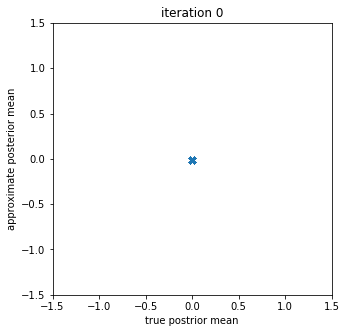

epoch 1 iteration 0 loss 62.162 CE 62.162 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 100 loss 49.757 CE 49.757 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 200 loss 45.407 CE 45.407 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 300 loss 43.536 CE 43.534 KL 0.002 weighted KL: 0.002 weight 1.000
epoch 1 iteration 400 loss 45.663 CE 45.662 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 500 loss 44.124 CE 44.124 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 600 loss 41.946 CE 41.944 KL 0.002 weighted KL: 0.002 weight 1.000
epoch 1 iteration 700 loss 41.374 CE 41.373 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 800 loss 45.844 CE 45.843 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 1 iteration 900 loss 40.899 CE 40.896 KL 0.004 weighted KL: 0.004 weight 1.000
Epoch [1/30], Training Loss: 40.0992,  Training KL: 0.0005, Training Perplexity: 86.10, Validation Loss: 43.6998, KL 0.0005, Val Perplexity: 128.45



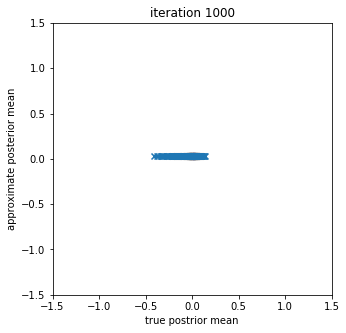

epoch 2 iteration 1000 loss 41.673 CE 41.673 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 2 iteration 1100 loss 38.866 CE 38.866 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 2 iteration 1200 loss 36.329 CE 36.329 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 2 iteration 1300 loss 42.573 CE 42.571 KL 0.002 weighted KL: 0.002 weight 1.000
epoch 2 iteration 1400 loss 40.921 CE 40.911 KL 0.010 weighted KL: 0.010 weight 1.000
epoch 2 iteration 1500 loss 29.543 CE 29.542 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 2 iteration 1600 loss 39.991 CE 39.991 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 2 iteration 1700 loss 31.898 CE 31.898 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 2 iteration 1800 loss 41.229 CE 41.229 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 2 iteration 1900 loss 32.791 CE 32.731 KL 0.060 weighted KL: 0.060 weight 1.000
Epoch [2/30], Training Loss: 35.2667,  Training KL: 0.0000, Training Perplexity: 50.33, Validation Loss: 38.6664, KL 0.0000, Val Perplexity:

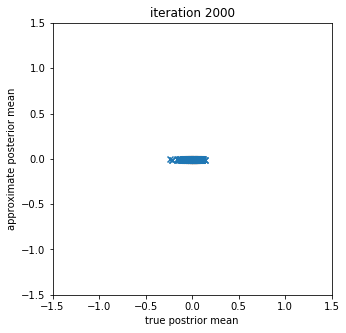

epoch 3 iteration 2000 loss 33.401 CE 33.401 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 3 iteration 2100 loss 38.082 CE 38.082 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 3 iteration 2200 loss 36.189 CE 36.189 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 3 iteration 2300 loss 32.801 CE 32.801 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 3 iteration 2400 loss 33.429 CE 33.429 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 3 iteration 2500 loss 37.606 CE 37.606 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 3 iteration 2600 loss 31.829 CE 31.829 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 3 iteration 2700 loss 33.529 CE 33.529 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 3 iteration 2800 loss 32.955 CE 32.955 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 3 iteration 2900 loss 37.488 CE 37.488 KL 0.000 weighted KL: 0.000 weight 1.000
Epoch [3/30], Training Loss: 33.7955,  Training KL: 0.0001, Training Perplexity: 42.74, Validation Loss: 37.3016, KL 0.0001, Val Perplexity:

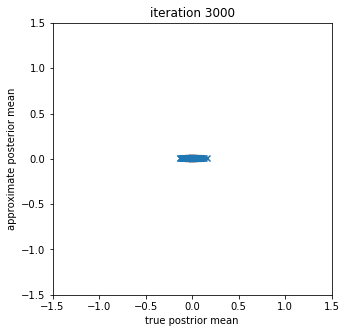

epoch 4 iteration 3000 loss 35.881 CE 35.881 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 4 iteration 3100 loss 32.398 CE 32.397 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 4 iteration 3200 loss 34.529 CE 34.529 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 4 iteration 3300 loss 36.376 CE 36.376 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 4 iteration 3400 loss 37.195 CE 37.195 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 4 iteration 3500 loss 35.996 CE 35.996 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 4 iteration 3600 loss 34.150 CE 34.150 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 4 iteration 3700 loss 34.770 CE 34.770 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 4 iteration 3800 loss 34.321 CE 34.321 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 4 iteration 3900 loss 37.409 CE 37.409 KL 0.000 weighted KL: 0.000 weight 1.000
Epoch [4/30], Training Loss: 33.1602,  Training KL: 0.0000, Training Perplexity: 39.82, Validation Loss: 37.2246, KL 0.0000, Val Perplexity:

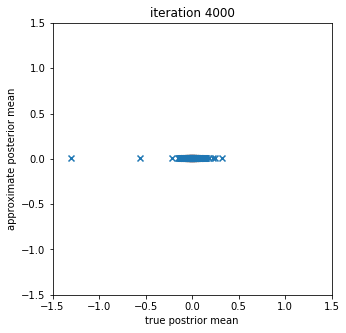

epoch 5 iteration 4000 loss 33.235 CE 33.235 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 5 iteration 4100 loss 28.500 CE 28.499 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 5 iteration 4200 loss 28.995 CE 28.994 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 5 iteration 4300 loss 33.217 CE 33.217 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 5 iteration 4400 loss 35.226 CE 35.226 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 5 iteration 4500 loss 30.155 CE 30.155 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 5 iteration 4600 loss 35.650 CE 35.650 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 5 iteration 4700 loss 34.701 CE 34.700 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 5 iteration 4800 loss 32.313 CE 32.313 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 5 iteration 4900 loss 33.459 CE 33.459 KL 0.000 weighted KL: 0.000 weight 1.000
Epoch [5/30], Training Loss: 32.7693,  Training KL: 0.0006, Training Perplexity: 38.13, Validation Loss: 37.0152, KL 0.0006, Val Perplexity:

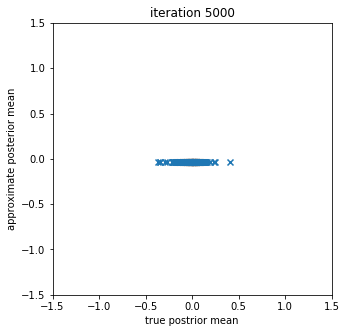

epoch 6 iteration 5000 loss 30.088 CE 30.088 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 6 iteration 5100 loss 34.531 CE 34.531 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 6 iteration 5200 loss 36.932 CE 36.932 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 6 iteration 5300 loss 30.291 CE 30.291 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 6 iteration 5400 loss 31.837 CE 31.837 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 6 iteration 5500 loss 30.825 CE 30.825 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 6 iteration 5600 loss 29.572 CE 29.572 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 6 iteration 5700 loss 27.344 CE 27.344 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 6 iteration 5800 loss 40.411 CE 40.411 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 6 iteration 5900 loss 32.634 CE 32.633 KL 0.001 weighted KL: 0.001 weight 1.000
Epoch [6/30], Training Loss: 32.5427,  Training KL: 0.0000, Training Perplexity: 37.18, Validation Loss: 36.8186, KL 0.0000, Val Perplexity:

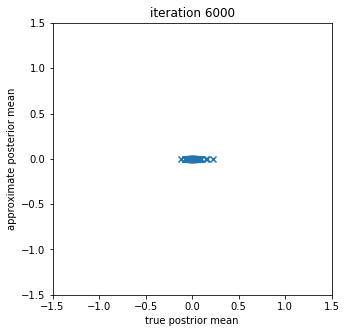

epoch 7 iteration 6000 loss 32.005 CE 32.005 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 7 iteration 6100 loss 33.225 CE 33.225 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 7 iteration 6200 loss 34.199 CE 34.199 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 7 iteration 6300 loss 36.827 CE 36.827 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 7 iteration 6400 loss 31.353 CE 31.353 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 7 iteration 6500 loss 38.595 CE 38.594 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 7 iteration 6600 loss 29.759 CE 29.759 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 7 iteration 6700 loss 35.004 CE 35.004 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 7 iteration 6800 loss 32.241 CE 32.241 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 7 iteration 6900 loss 32.520 CE 32.520 KL 0.000 weighted KL: 0.000 weight 1.000
Epoch [7/30], Training Loss: 32.0347,  Training KL: 0.0000, Training Perplexity: 35.14, Validation Loss: 36.1959, KL 0.0000, Val Perplexity:

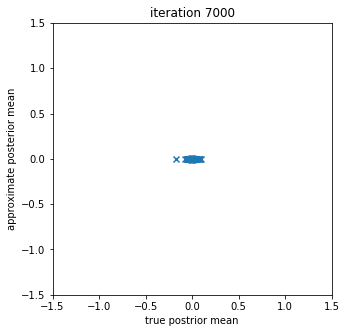

epoch 8 iteration 7000 loss 33.749 CE 33.749 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 8 iteration 7100 loss 29.247 CE 29.246 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 8 iteration 7200 loss 28.298 CE 28.298 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 8 iteration 7300 loss 29.627 CE 29.627 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 8 iteration 7400 loss 28.668 CE 28.668 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 8 iteration 7500 loss 28.591 CE 28.591 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 8 iteration 7600 loss 38.858 CE 38.858 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 8 iteration 7700 loss 27.038 CE 27.038 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 8 iteration 7800 loss 31.578 CE 31.562 KL 0.016 weighted KL: 0.016 weight 1.000
epoch 8 iteration 7900 loss 31.902 CE 31.902 KL 0.000 weighted KL: 0.000 weight 1.000
Epoch [8/30], Training Loss: 31.9882,  Training KL: 0.0000, Training Perplexity: 34.96, Validation Loss: 36.3117, KL 0.0000, Val Perplexity:

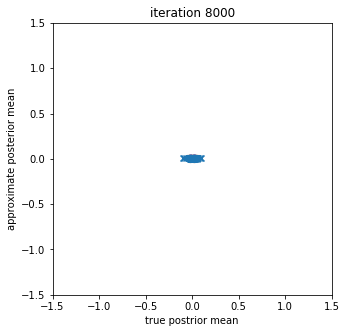

epoch 9 iteration 8000 loss 34.640 CE 34.640 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 9 iteration 8100 loss 28.076 CE 28.076 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 9 iteration 8200 loss 32.814 CE 32.814 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 9 iteration 8300 loss 28.000 CE 28.000 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 9 iteration 8400 loss 31.924 CE 31.924 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 9 iteration 8500 loss 34.254 CE 34.254 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 9 iteration 8600 loss 31.545 CE 31.545 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 9 iteration 8700 loss 32.001 CE 32.001 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 9 iteration 8800 loss 33.128 CE 33.128 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 9 iteration 8900 loss 32.693 CE 32.693 KL 0.000 weighted KL: 0.000 weight 1.000
Epoch [9/30], Training Loss: 31.6809,  Training KL: 0.0001, Training Perplexity: 33.79, Validation Loss: 36.2043, KL 0.0001, Val Perplexity:

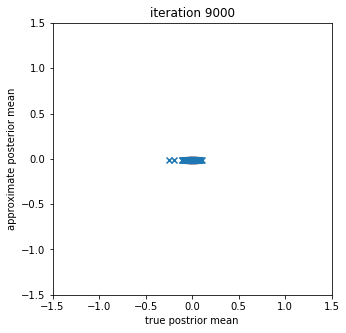

new lr: 0.500000
epoch 10 iteration 9000 loss 28.401 CE 28.401 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 10 iteration 9100 loss 32.028 CE 32.028 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 10 iteration 9200 loss 32.005 CE 32.005 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 10 iteration 9300 loss 33.111 CE 33.111 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 10 iteration 9400 loss 29.530 CE 29.530 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 10 iteration 9500 loss 28.132 CE 28.132 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 10 iteration 9600 loss 30.591 CE 30.591 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 10 iteration 9700 loss 30.204 CE 30.204 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 10 iteration 9800 loss 29.704 CE 29.704 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 10 iteration 9900 loss 32.872 CE 32.872 KL 0.000 weighted KL: 0.000 weight 1.000
Epoch [10/30], Training Loss: 31.1773,  Training KL: 0.0000, Training Perplexity: 31.95, Validation Loss: 35.8454

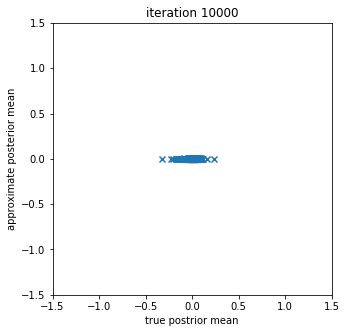

epoch 11 iteration 10000 loss 32.059 CE 32.059 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 11 iteration 10100 loss 31.906 CE 31.906 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 11 iteration 10200 loss 29.919 CE 29.919 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 11 iteration 10300 loss 25.014 CE 25.014 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 11 iteration 10400 loss 27.787 CE 27.787 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 11 iteration 10500 loss 32.462 CE 32.462 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 11 iteration 10600 loss 34.651 CE 34.651 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 11 iteration 10700 loss 31.799 CE 31.799 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 11 iteration 10800 loss 32.010 CE 32.010 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 11 iteration 10900 loss 39.167 CE 39.167 KL 0.000 weighted KL: 0.000 weight 1.000
Epoch [11/30], Training Loss: 30.9993,  Training KL: 0.0000, Training Perplexity: 31.32, Validation Loss: 35.8406, KL 0.

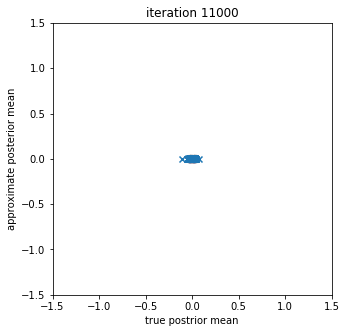

epoch 12 iteration 11000 loss 37.477 CE 37.477 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 12 iteration 11100 loss 33.560 CE 33.560 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 12 iteration 11200 loss 30.012 CE 30.012 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 12 iteration 11300 loss 33.453 CE 33.453 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 12 iteration 11400 loss 32.408 CE 32.408 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 12 iteration 11500 loss 27.900 CE 27.900 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 12 iteration 11600 loss 27.837 CE 27.837 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 12 iteration 11700 loss 28.809 CE 28.809 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 12 iteration 11800 loss 30.862 CE 30.862 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 12 iteration 11900 loss 32.289 CE 32.289 KL 0.000 weighted KL: 0.000 weight 1.000
Epoch [12/30], Training Loss: 30.9495,  Training KL: 0.0000, Training Perplexity: 31.15, Validation Loss: 35.8632, KL 0.

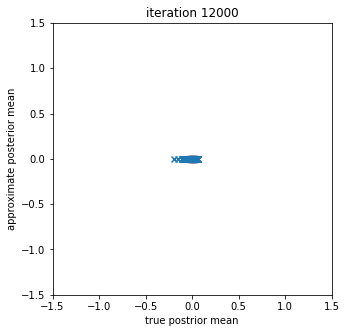

epoch 13 iteration 12000 loss 27.497 CE 27.497 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 13 iteration 12100 loss 27.127 CE 27.127 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 13 iteration 12200 loss 31.404 CE 31.404 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 13 iteration 12300 loss 27.618 CE 27.618 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 13 iteration 12400 loss 32.699 CE 32.699 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 13 iteration 12500 loss 32.527 CE 32.527 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 13 iteration 12600 loss 30.558 CE 30.558 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 13 iteration 12700 loss 33.112 CE 33.112 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 13 iteration 12800 loss 30.866 CE 30.866 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 13 iteration 12900 loss 30.032 CE 30.032 KL 0.000 weighted KL: 0.000 weight 1.000
Epoch [13/30], Training Loss: 30.9036,  Training KL: 0.0000, Training Perplexity: 30.99, Validation Loss: 35.9568, KL 0.

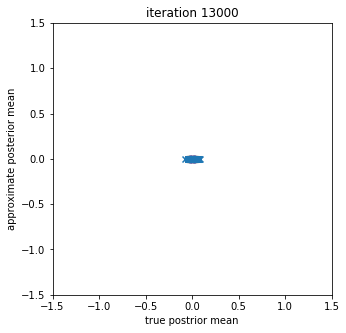

new lr: 0.250000
epoch 14 iteration 13000 loss 31.587 CE 31.587 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 14 iteration 13100 loss 32.363 CE 32.363 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 14 iteration 13200 loss 30.337 CE 30.337 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 14 iteration 13300 loss 32.155 CE 32.155 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 14 iteration 13400 loss 28.763 CE 28.763 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 14 iteration 13500 loss 30.775 CE 30.775 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 14 iteration 13600 loss 30.955 CE 30.955 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 14 iteration 13700 loss 28.728 CE 28.728 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 14 iteration 13800 loss 29.804 CE 29.804 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 14 iteration 13900 loss 27.114 CE 27.114 KL 0.000 weighted KL: 0.000 weight 1.000
Epoch [14/30], Training Loss: 30.6187,  Training KL: 0.0000, Training Perplexity: 30.03, Validation Los

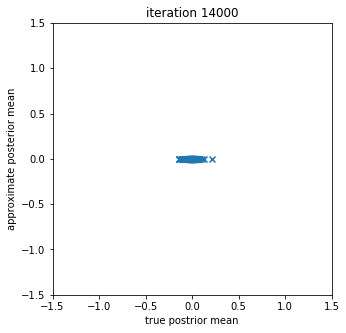

epoch 15 iteration 14000 loss 29.775 CE 29.775 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 15 iteration 14100 loss 28.104 CE 28.104 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 15 iteration 14200 loss 30.992 CE 30.992 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 15 iteration 14300 loss 38.004 CE 38.004 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 15 iteration 14400 loss 32.414 CE 32.414 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 15 iteration 14500 loss 32.779 CE 32.779 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 15 iteration 14600 loss 30.121 CE 30.121 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 15 iteration 14700 loss 32.119 CE 32.119 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 15 iteration 14800 loss 31.419 CE 31.419 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 15 iteration 14900 loss 32.674 CE 32.674 KL 0.000 weighted KL: 0.000 weight 1.000
Epoch [15/30], Training Loss: 30.6211,  Training KL: 0.0000, Training Perplexity: 30.03, Validation Loss: 35.8170, KL 0.

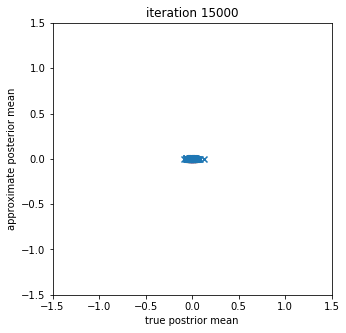

epoch 16 iteration 15000 loss 35.709 CE 35.709 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 16 iteration 15100 loss 29.568 CE 29.568 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 16 iteration 15200 loss 30.137 CE 30.137 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 16 iteration 15300 loss 29.806 CE 29.806 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 16 iteration 15400 loss 31.506 CE 31.506 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 16 iteration 15500 loss 25.847 CE 25.847 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 16 iteration 15600 loss 32.716 CE 32.716 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 16 iteration 15700 loss 30.522 CE 30.522 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 16 iteration 15800 loss 32.960 CE 32.960 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 16 iteration 15900 loss 26.896 CE 26.896 KL 0.000 weighted KL: 0.000 weight 1.000
Epoch [16/30], Training Loss: 30.5230,  Training KL: 0.0000, Training Perplexity: 29.71, Validation Loss: 35.8436, KL 0.

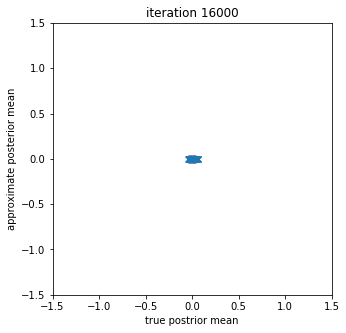

epoch 17 iteration 16000 loss 29.320 CE 29.320 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 17 iteration 16100 loss 35.609 CE 35.609 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 17 iteration 16200 loss 31.601 CE 31.601 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 17 iteration 16300 loss 29.046 CE 29.046 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 17 iteration 16400 loss 30.530 CE 30.530 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 17 iteration 16500 loss 27.713 CE 27.713 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 17 iteration 16600 loss 24.997 CE 24.997 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 17 iteration 16700 loss 29.079 CE 29.079 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 17 iteration 16800 loss 34.063 CE 34.063 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 17 iteration 16900 loss 28.883 CE 28.883 KL 0.000 weighted KL: 0.000 weight 1.000
Epoch [17/30], Training Loss: 30.5276,  Training KL: 0.0000, Training Perplexity: 29.72, Validation Loss: 36.2159, KL 0.

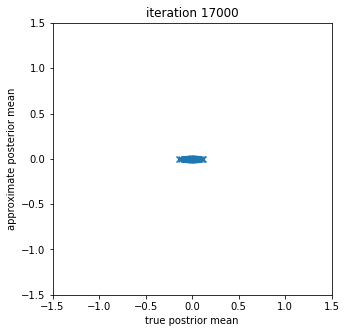

new lr: 0.125000
epoch 18 iteration 17000 loss 29.333 CE 29.333 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 18 iteration 17100 loss 29.983 CE 29.983 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 18 iteration 17200 loss 28.313 CE 28.313 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 18 iteration 17300 loss 36.472 CE 36.472 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 18 iteration 17400 loss 34.019 CE 34.019 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 18 iteration 17500 loss 29.532 CE 29.532 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 18 iteration 17600 loss 31.969 CE 31.969 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 18 iteration 17700 loss 32.059 CE 32.059 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 18 iteration 17800 loss 32.816 CE 32.816 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 18 iteration 17900 loss 32.752 CE 32.752 KL 0.000 weighted KL: 0.000 weight 1.000
Epoch [18/30], Training Loss: 30.3699,  Training KL: 0.0000, Training Perplexity: 29.21, Validation Los

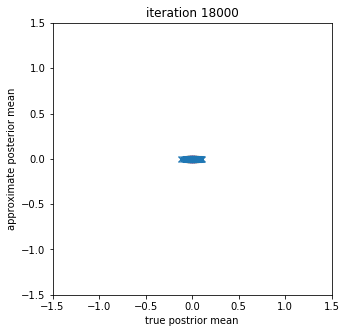

epoch 19 iteration 18000 loss 27.654 CE 27.654 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 19 iteration 18100 loss 30.299 CE 30.299 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 19 iteration 18200 loss 30.259 CE 30.259 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 19 iteration 18300 loss 28.131 CE 28.131 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 19 iteration 18400 loss 28.686 CE 28.686 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 19 iteration 18500 loss 33.138 CE 33.138 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 19 iteration 18600 loss 34.412 CE 34.412 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 19 iteration 18700 loss 26.776 CE 26.776 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 19 iteration 18800 loss 29.467 CE 29.467 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 19 iteration 18900 loss 24.692 CE 24.692 KL 0.000 weighted KL: 0.000 weight 1.000
Epoch [19/30], Training Loss: 30.3066,  Training KL: 0.0000, Training Perplexity: 29.00, Validation Loss: 35.9668, KL 0.

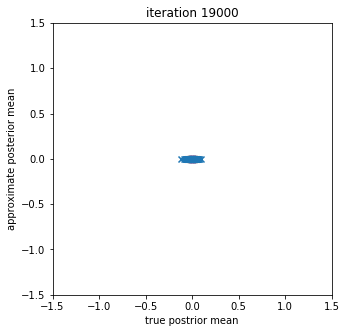

epoch 20 iteration 19000 loss 29.980 CE 29.980 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 20 iteration 19100 loss 31.709 CE 31.709 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 20 iteration 19200 loss 27.149 CE 27.149 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 20 iteration 19300 loss 27.692 CE 27.692 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 20 iteration 19400 loss 24.563 CE 24.563 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 20 iteration 19500 loss 31.284 CE 31.284 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 20 iteration 19600 loss 28.584 CE 28.584 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 20 iteration 19700 loss 30.271 CE 30.271 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 20 iteration 19800 loss 28.770 CE 28.770 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 20 iteration 19900 loss 30.090 CE 30.090 KL 0.000 weighted KL: 0.000 weight 1.000
Epoch [20/30], Training Loss: 30.2977,  Training KL: 0.0000, Training Perplexity: 28.97, Validation Loss: 36.0233, KL 0.

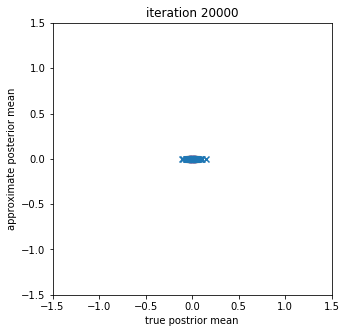

new lr: 0.062500
epoch 21 iteration 20000 loss 29.757 CE 29.757 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 21 iteration 20100 loss 30.292 CE 30.292 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 21 iteration 20200 loss 28.992 CE 28.992 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 21 iteration 20300 loss 27.949 CE 27.949 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 21 iteration 20400 loss 30.715 CE 30.715 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 21 iteration 20500 loss 32.327 CE 32.327 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 21 iteration 20600 loss 33.418 CE 33.418 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 21 iteration 20700 loss 34.546 CE 34.546 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 21 iteration 20800 loss 32.851 CE 32.851 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 21 iteration 20900 loss 31.217 CE 31.217 KL 0.000 weighted KL: 0.000 weight 1.000
Epoch [21/30], Training Loss: 30.2165,  Training KL: 0.0000, Training Perplexity: 28.71, Validation Los

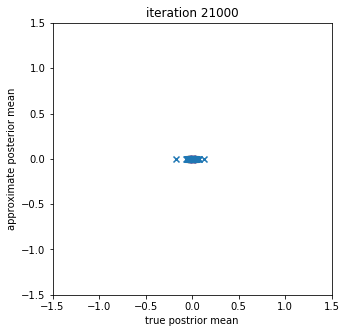

epoch 22 iteration 21000 loss 31.134 CE 31.134 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 22 iteration 21100 loss 22.474 CE 22.474 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 22 iteration 21200 loss 28.325 CE 28.325 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 22 iteration 21300 loss 29.035 CE 29.035 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 22 iteration 21400 loss 35.051 CE 35.051 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 22 iteration 21500 loss 24.581 CE 24.581 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 22 iteration 21600 loss 28.640 CE 28.640 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 22 iteration 21700 loss 26.273 CE 26.273 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 22 iteration 21800 loss 32.614 CE 32.614 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 22 iteration 21900 loss 30.089 CE 30.089 KL 0.000 weighted KL: 0.000 weight 1.000
Epoch [22/30], Training Loss: 30.1995,  Training KL: 0.0000, Training Perplexity: 28.66, Validation Loss: 36.0223, KL 0.

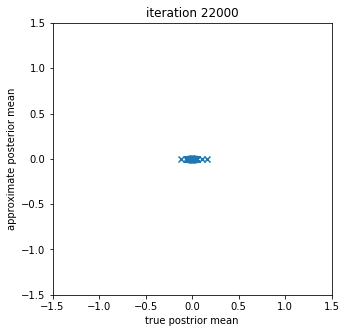

epoch 23 iteration 22000 loss 30.064 CE 30.064 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 23 iteration 22100 loss 29.456 CE 29.456 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 23 iteration 22200 loss 30.419 CE 30.419 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 23 iteration 22300 loss 30.219 CE 30.219 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 23 iteration 22400 loss 31.271 CE 31.271 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 23 iteration 22500 loss 32.333 CE 32.333 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 23 iteration 22600 loss 29.627 CE 29.627 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 23 iteration 22700 loss 31.048 CE 31.048 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 23 iteration 22800 loss 32.210 CE 32.210 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 23 iteration 22900 loss 32.511 CE 32.511 KL 0.000 weighted KL: 0.000 weight 1.000
Epoch [23/30], Training Loss: 30.1912,  Training KL: 0.0000, Training Perplexity: 28.63, Validation Loss: 36.0714, KL 0.

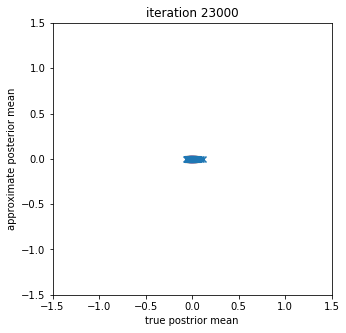

epoch 24 iteration 23000 loss 29.078 CE 29.078 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 24 iteration 23100 loss 28.684 CE 28.684 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 24 iteration 23200 loss 27.418 CE 27.418 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 24 iteration 23300 loss 29.896 CE 29.896 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 24 iteration 23400 loss 28.971 CE 28.971 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 24 iteration 23500 loss 32.196 CE 32.196 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 24 iteration 23600 loss 29.265 CE 29.265 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 24 iteration 23700 loss 25.527 CE 25.527 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 24 iteration 23800 loss 30.472 CE 30.472 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 24 iteration 23900 loss 25.346 CE 25.346 KL 0.000 weighted KL: 0.000 weight 1.000
Epoch [24/30], Training Loss: 30.1936,  Training KL: 0.0000, Training Perplexity: 28.64, Validation Loss: 36.0580, KL 0.

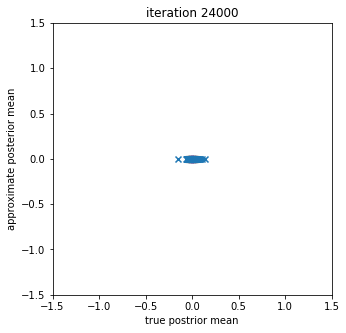

new lr: 0.031250


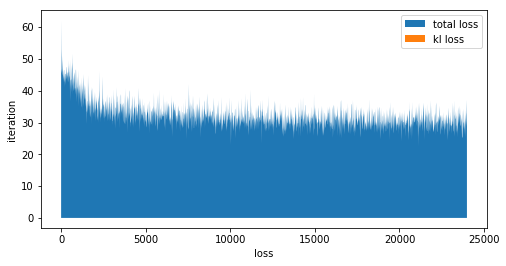

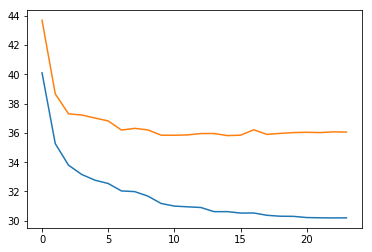

In [174]:
# without annealing
vocab_size = 1000
hidden_size = 50
embedding_size = 50
latent_size = 1
num_layers = 1
step = 0.25
learning_rate = 1.0
epochs = 30
max_sentence_length = 10

embedding_weights = nn.Embedding(vocab_size, embedding_size).weight
vae = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=True)

train(vae, inputs, targets, val_inputs, val_inputs, epochs, vocab_size, hidden_size, latent_size, max_sentence_length, plot=True, learning_rate=learning_rate,
      synthetic=True, step=step, tracked_inputs=tracked_inputs, tracked_targets=tracked_targets, plot_lim=1.5, verbose=True)

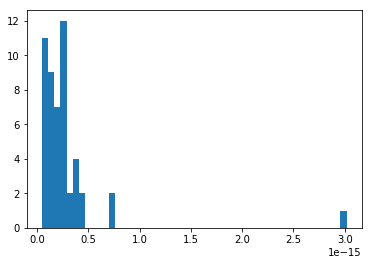

In [146]:
hist_active_units(vae, inputs)

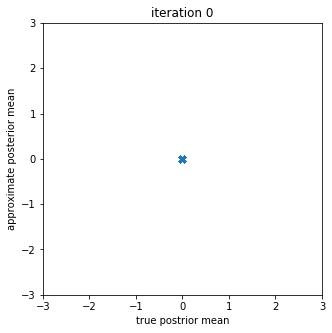

epoch 1 iteration 0 loss 62.169 CE 62.169 KL 0.000 weighted KL: 0.000 weight 0.002
epoch 1 iteration 100 loss 45.665 CE 45.665 KL 0.033 weighted KL: 0.000 weight 0.002
epoch 1 iteration 200 loss 42.363 CE 42.363 KL 0.025 weighted KL: 0.000 weight 0.003
epoch 1 iteration 300 loss 44.424 CE 44.423 KL 0.034 weighted KL: 0.000 weight 0.004
epoch 1 iteration 400 loss 41.619 CE 41.619 KL 0.058 weighted KL: 0.000 weight 0.005
epoch 1 iteration 500 loss 43.624 CE 43.624 KL 0.063 weighted KL: 0.000 weight 0.007
epoch 1 iteration 600 loss 41.719 CE 41.719 KL 0.070 weighted KL: 0.001 weight 0.009
epoch 1 iteration 700 loss 45.554 CE 45.554 KL 0.068 weighted KL: 0.001 weight 0.011
epoch 1 iteration 800 loss 42.917 CE 42.916 KL 0.084 weighted KL: 0.001 weight 0.014
epoch 1 iteration 900 loss 39.988 CE 39.987 KL 0.038 weighted KL: 0.001 weight 0.018
Epoch [1/10], Training Loss: 39.0413,  Training KL: 0.0012, Training Perplexity: 76.55, Validation Loss: 39.2781, KL 0.0012, Val Perplexity: 78.59



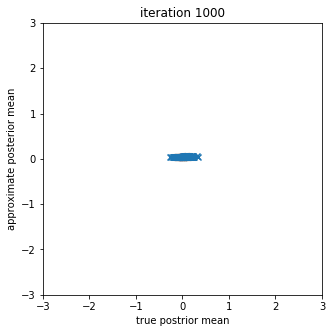

epoch 2 iteration 1000 loss 43.815 CE 43.814 KL 0.052 weighted KL: 0.001 weight 0.023
epoch 2 iteration 1100 loss 42.495 CE 42.494 KL 0.039 weighted KL: 0.001 weight 0.029
epoch 2 iteration 1200 loss 37.611 CE 37.609 KL 0.057 weighted KL: 0.002 weight 0.037
epoch 2 iteration 1300 loss 32.342 CE 32.341 KL 0.011 weighted KL: 0.001 weight 0.047
epoch 2 iteration 1400 loss 33.541 CE 33.540 KL 0.010 weighted KL: 0.001 weight 0.060
epoch 2 iteration 1500 loss 39.718 CE 39.716 KL 0.025 weighted KL: 0.002 weight 0.076
epoch 2 iteration 1600 loss 34.580 CE 34.579 KL 0.003 weighted KL: 0.000 weight 0.095
epoch 2 iteration 1700 loss 35.352 CE 35.351 KL 0.007 weighted KL: 0.001 weight 0.119
epoch 2 iteration 1800 loss 35.641 CE 35.641 KL 0.002 weighted KL: 0.000 weight 0.148
epoch 2 iteration 1900 loss 32.786 CE 32.785 KL 0.009 weighted KL: 0.002 weight 0.182
Epoch [2/10], Training Loss: 35.2756,  Training KL: 0.0001, Training Perplexity: 50.38, Validation Loss: 35.6802, KL 0.0001, Val Perplexity:

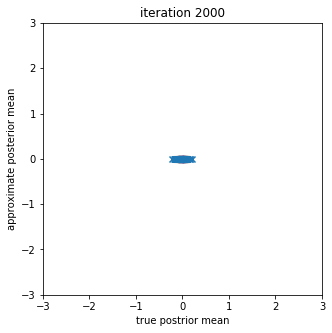

epoch 3 iteration 2000 loss 35.904 CE 35.904 KL 0.000 weighted KL: 0.000 weight 0.223
epoch 3 iteration 2100 loss 34.544 CE 34.544 KL 0.000 weighted KL: 0.000 weight 0.269
epoch 3 iteration 2200 loss 35.064 CE 35.063 KL 0.004 weighted KL: 0.001 weight 0.321
epoch 3 iteration 2300 loss 36.474 CE 36.463 KL 0.027 weighted KL: 0.010 weight 0.378
epoch 3 iteration 2400 loss 34.897 CE 34.896 KL 0.001 weighted KL: 0.001 weight 0.438
epoch 3 iteration 2500 loss 32.924 CE 32.924 KL 0.001 weighted KL: 0.000 weight 0.500
epoch 3 iteration 2600 loss 32.473 CE 32.473 KL 0.000 weighted KL: 0.000 weight 0.562
epoch 3 iteration 2700 loss 31.802 CE 31.802 KL 0.000 weighted KL: 0.000 weight 0.622
epoch 3 iteration 2800 loss 31.257 CE 31.253 KL 0.005 weighted KL: 0.003 weight 0.679
epoch 3 iteration 2900 loss 35.851 CE 35.851 KL 0.000 weighted KL: 0.000 weight 0.731
Epoch [3/10], Training Loss: 34.0558,  Training KL: 0.0007, Training Perplexity: 43.99, Validation Loss: 34.6032, KL 0.0007, Val Perplexity:

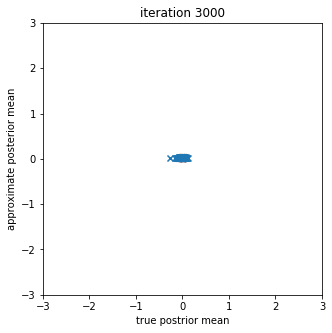

epoch 4 iteration 3000 loss 37.381 CE 37.381 KL 0.001 weighted KL: 0.001 weight 0.777
epoch 4 iteration 3100 loss 33.441 CE 33.441 KL 0.000 weighted KL: 0.000 weight 0.818
epoch 4 iteration 3200 loss 35.570 CE 35.570 KL 0.000 weighted KL: 0.000 weight 0.852
epoch 4 iteration 3300 loss 31.795 CE 31.795 KL 0.000 weighted KL: 0.000 weight 0.881
epoch 4 iteration 3400 loss 32.752 CE 32.751 KL 0.000 weighted KL: 0.000 weight 0.905
epoch 4 iteration 3500 loss 32.641 CE 32.641 KL 0.000 weighted KL: 0.000 weight 0.924
epoch 4 iteration 3600 loss 35.304 CE 35.304 KL 0.000 weighted KL: 0.000 weight 0.940
epoch 4 iteration 3700 loss 29.363 CE 29.363 KL 0.000 weighted KL: 0.000 weight 0.953
epoch 4 iteration 3800 loss 34.281 CE 34.281 KL 0.000 weighted KL: 0.000 weight 0.963
epoch 4 iteration 3900 loss 29.616 CE 29.616 KL 0.000 weighted KL: 0.000 weight 0.971
Epoch [4/10], Training Loss: 33.1910,  Training KL: 0.0001, Training Perplexity: 39.96, Validation Loss: 33.7746, KL 0.0000, Val Perplexity:

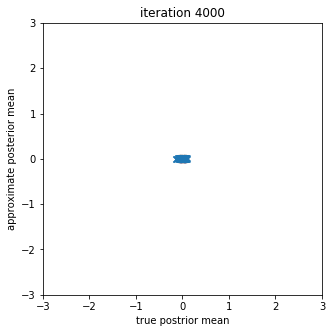

epoch 5 iteration 4000 loss 31.933 CE 31.933 KL 0.000 weighted KL: 0.000 weight 0.977
epoch 5 iteration 4100 loss 26.722 CE 26.721 KL 0.001 weighted KL: 0.001 weight 0.982
epoch 5 iteration 4200 loss 34.503 CE 34.503 KL 0.000 weighted KL: 0.000 weight 0.986
epoch 5 iteration 4300 loss 38.696 CE 38.696 KL 0.000 weighted KL: 0.000 weight 0.989
epoch 5 iteration 4400 loss 30.260 CE 30.260 KL 0.000 weighted KL: 0.000 weight 0.991
epoch 5 iteration 4500 loss 31.690 CE 31.690 KL 0.000 weighted KL: 0.000 weight 0.993
epoch 5 iteration 4600 loss 33.060 CE 33.060 KL 0.000 weighted KL: 0.000 weight 0.995
epoch 5 iteration 4700 loss 32.940 CE 32.935 KL 0.006 weighted KL: 0.005 weight 0.996
epoch 5 iteration 4800 loss 36.570 CE 36.570 KL 0.000 weighted KL: 0.000 weight 0.997
epoch 5 iteration 4900 loss 29.865 CE 29.865 KL 0.000 weighted KL: 0.000 weight 0.998
Epoch [5/10], Training Loss: 32.9574,  Training KL: 0.0000, Training Perplexity: 38.94, Validation Loss: 33.5583, KL 0.0000, Val Perplexity:

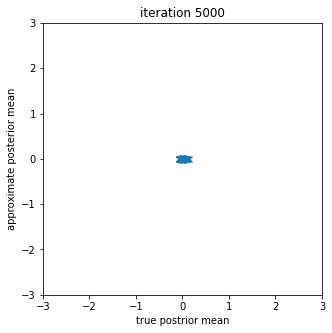

epoch 6 iteration 5000 loss 33.101 CE 33.101 KL 0.000 weighted KL: 0.000 weight 0.998
epoch 6 iteration 5100 loss 36.883 CE 36.883 KL 0.000 weighted KL: 0.000 weight 0.998
epoch 6 iteration 5200 loss 30.788 CE 30.787 KL 0.000 weighted KL: 0.000 weight 0.999
epoch 6 iteration 5300 loss 31.914 CE 31.914 KL 0.000 weighted KL: 0.000 weight 0.999
epoch 6 iteration 5400 loss 35.218 CE 35.218 KL 0.000 weighted KL: 0.000 weight 0.999
epoch 6 iteration 5500 loss 35.799 CE 35.799 KL 0.000 weighted KL: 0.000 weight 0.999
epoch 6 iteration 5600 loss 32.830 CE 32.830 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 6 iteration 5700 loss 28.975 CE 28.975 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 6 iteration 5800 loss 29.276 CE 29.276 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 6 iteration 5900 loss 30.988 CE 30.988 KL 0.001 weighted KL: 0.001 weight 1.000
Epoch [6/10], Training Loss: 35.9184,  Training KL: 3.0398, Training Perplexity: 54.11, Validation Loss: 36.5662, KL 3.0396, Val Perplexity:

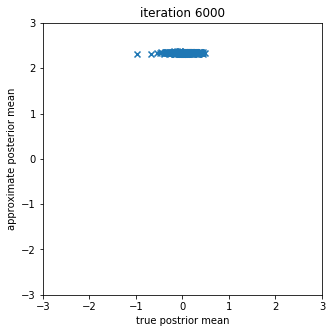

epoch 7 iteration 6000 loss 40.007 CE 36.960 KL 3.048 weighted KL: 3.048 weight 1.000
epoch 7 iteration 6100 loss 32.957 CE 32.957 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 7 iteration 6200 loss 33.943 CE 33.943 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 7 iteration 6300 loss 29.096 CE 29.096 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 7 iteration 6400 loss 35.138 CE 35.138 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 7 iteration 6500 loss 31.268 CE 31.268 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 7 iteration 6600 loss 29.045 CE 29.045 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 7 iteration 6700 loss 29.148 CE 29.148 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 7 iteration 6800 loss 31.651 CE 31.651 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 7 iteration 6900 loss 30.248 CE 30.248 KL 0.000 weighted KL: 0.000 weight 1.000
Epoch [7/10], Training Loss: 32.2142,  Training KL: 0.0000, Training Perplexity: 35.85, Validation Loss: 32.9248, KL 0.0000, Val Perplexity:

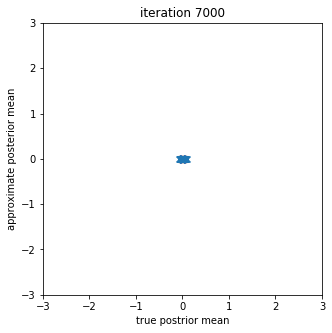

epoch 8 iteration 7000 loss 32.199 CE 32.199 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 8 iteration 7100 loss 28.750 CE 28.750 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 8 iteration 7200 loss 38.729 CE 38.729 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 8 iteration 7300 loss 31.009 CE 31.009 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 8 iteration 7400 loss 33.386 CE 33.386 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 8 iteration 7500 loss 31.746 CE 31.746 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 8 iteration 7600 loss 29.468 CE 29.467 KL 0.000 weighted KL: 0.000 weight 1.000


KeyboardInterrupt: 

In [175]:
#with annealing
vocab_size = 1000
hidden_size = 50
embedding_size = 50
latent_size = 1
num_layers = 1
step = 0.25
learning_rate = 1.0
epochs = 10
max_sentence_length = 10

embedding_weights = nn.Embedding(vocab_size, embedding_size).weight
vae = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=True)

annealing_args = {'type':'logistic', 'step':0, 'k':0.0025, 'first_step':2500}

train(vae, inputs, targets, val_inputs, val_targets, epochs, vocab_size, hidden_size, latent_size, max_sentence_length, plot=True, learning_rate=learning_rate,
      synthetic=True, step=step, plot_lim=3, annealing_args=annealing_args, tracked_inputs=tracked_inputs, 
      tracked_targets=tracked_targets)

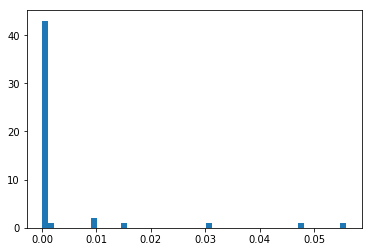

In [27]:
hist_active_units(vae, inputs)

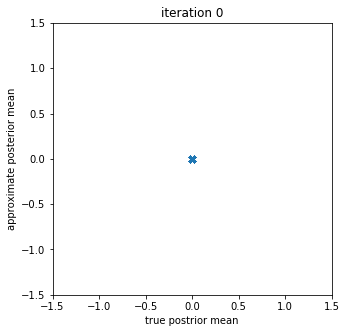

epoch 1 iteration 0 loss 62.166 CE 62.166 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 100 loss 46.412 CE 46.412 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 200 loss 42.047 CE 42.030 KL 0.017 weighted KL: 0.017 weight 1.000
epoch 1 iteration 300 loss 36.667 CE 35.740 KL 0.928 weighted KL: 0.928 weight 1.000
epoch 1 iteration 400 loss 43.242 CE 41.735 KL 1.507 weighted KL: 1.507 weight 1.000
epoch 1 iteration 500 loss 36.565 CE 35.040 KL 1.525 weighted KL: 1.525 weight 1.000
epoch 1 iteration 600 loss 37.727 CE 36.105 KL 1.622 weighted KL: 1.622 weight 1.000
epoch 1 iteration 700 loss 35.500 CE 34.159 KL 1.341 weighted KL: 1.341 weight 1.000
epoch 1 iteration 800 loss 30.780 CE 29.095 KL 1.685 weighted KL: 1.685 weight 1.000
epoch 1 iteration 900 loss 30.313 CE 28.603 KL 1.711 weighted KL: 1.711 weight 1.000
current_mi: 2.784955920219421


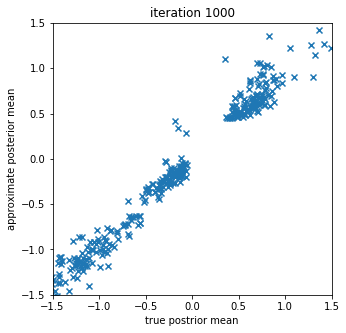

Epoch [1/10], Loss: 34.0570, Perplexity: 617694098955783.88

epoch 2 iteration 1000 loss 32.562 CE 30.529 KL 2.033 weighted KL: 2.033 weight 1.000
epoch 2 iteration 1100 loss 35.682 CE 33.866 KL 1.816 weighted KL: 1.816 weight 1.000
epoch 2 iteration 1200 loss 32.121 CE 30.538 KL 1.583 weighted KL: 1.583 weight 1.000
epoch 2 iteration 1300 loss 34.066 CE 32.449 KL 1.617 weighted KL: 1.617 weight 1.000
epoch 2 iteration 1400 loss 29.202 CE 27.411 KL 1.791 weighted KL: 1.791 weight 1.000
epoch 2 iteration 1500 loss 33.211 CE 31.493 KL 1.718 weighted KL: 1.718 weight 1.000
epoch 2 iteration 1600 loss 32.780 CE 31.002 KL 1.778 weighted KL: 1.778 weight 1.000
epoch 2 iteration 1700 loss 34.169 CE 32.267 KL 1.902 weighted KL: 1.902 weight 1.000
epoch 2 iteration 1800 loss 29.852 CE 28.153 KL 1.699 weighted KL: 1.699 weight 1.000
epoch 2 iteration 1900 loss 28.818 CE 27.077 KL 1.741 weighted KL: 1.741 weight 1.000
current_mi: 2.768110426902771
STOP AGGRESSIVE


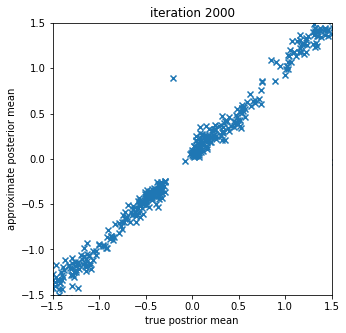

Epoch [2/10], Loss: 29.9853, Perplexity: 10530432636773.35

epoch 3 iteration 2000 loss 35.859 CE 33.950 KL 1.909 weighted KL: 1.909 weight 1.000
epoch 3 iteration 2100 loss 34.609 CE 32.743 KL 1.866 weighted KL: 1.866 weight 1.000
epoch 3 iteration 2200 loss 35.737 CE 33.951 KL 1.785 weighted KL: 1.785 weight 1.000
epoch 3 iteration 2300 loss 32.114 CE 30.373 KL 1.741 weighted KL: 1.741 weight 1.000
epoch 3 iteration 2400 loss 31.221 CE 29.401 KL 1.820 weighted KL: 1.820 weight 1.000
epoch 3 iteration 2500 loss 29.183 CE 27.440 KL 1.743 weighted KL: 1.743 weight 1.000
epoch 3 iteration 2600 loss 30.691 CE 28.837 KL 1.854 weighted KL: 1.854 weight 1.000
epoch 3 iteration 2700 loss 35.156 CE 33.344 KL 1.812 weighted KL: 1.812 weight 1.000
epoch 3 iteration 2800 loss 29.516 CE 27.609 KL 1.908 weighted KL: 1.908 weight 1.000
epoch 3 iteration 2900 loss 31.360 CE 29.577 KL 1.783 weighted KL: 1.783 weight 1.000


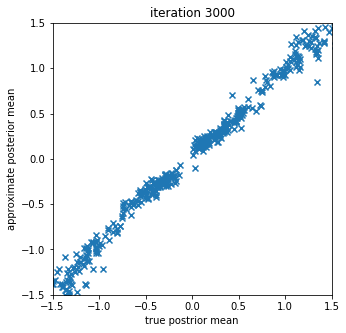

Epoch [3/10], Loss: 37.2339, Perplexity: 14806926307575568.00

epoch 4 iteration 3000 loss 34.495 CE 32.802 KL 1.693 weighted KL: 1.693 weight 1.000
epoch 4 iteration 3100 loss 33.940 CE 32.120 KL 1.821 weighted KL: 1.821 weight 1.000
epoch 4 iteration 3200 loss 28.214 CE 26.252 KL 1.962 weighted KL: 1.962 weight 1.000
epoch 4 iteration 3300 loss 31.411 CE 29.598 KL 1.813 weighted KL: 1.813 weight 1.000
epoch 4 iteration 3400 loss 31.663 CE 29.797 KL 1.866 weighted KL: 1.866 weight 1.000
epoch 4 iteration 3500 loss 35.135 CE 33.439 KL 1.696 weighted KL: 1.696 weight 1.000
epoch 4 iteration 3600 loss 34.205 CE 32.391 KL 1.813 weighted KL: 1.813 weight 1.000
epoch 4 iteration 3700 loss 34.577 CE 32.881 KL 1.697 weighted KL: 1.697 weight 1.000
epoch 4 iteration 3800 loss 28.141 CE 26.386 KL 1.755 weighted KL: 1.755 weight 1.000
epoch 4 iteration 3900 loss 32.598 CE 30.836 KL 1.762 weighted KL: 1.762 weight 1.000


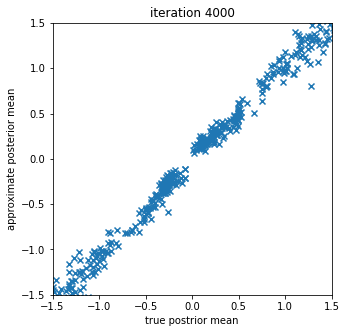

Epoch [4/10], Loss: 28.3979, Perplexity: 2152989907921.87

epoch 5 iteration 4000 loss 34.406 CE 32.495 KL 1.911 weighted KL: 1.911 weight 1.000
epoch 5 iteration 4100 loss 32.940 CE 31.140 KL 1.800 weighted KL: 1.800 weight 1.000
epoch 5 iteration 4200 loss 27.638 CE 25.906 KL 1.731 weighted KL: 1.731 weight 1.000
epoch 5 iteration 4300 loss 24.623 CE 22.839 KL 1.784 weighted KL: 1.784 weight 1.000
epoch 5 iteration 4400 loss 31.576 CE 29.775 KL 1.802 weighted KL: 1.802 weight 1.000
epoch 5 iteration 4500 loss 32.325 CE 30.626 KL 1.699 weighted KL: 1.699 weight 1.000
epoch 5 iteration 4600 loss 37.000 CE 35.302 KL 1.699 weighted KL: 1.699 weight 1.000
epoch 5 iteration 4700 loss 31.131 CE 29.307 KL 1.824 weighted KL: 1.824 weight 1.000
epoch 5 iteration 4800 loss 29.089 CE 27.272 KL 1.818 weighted KL: 1.818 weight 1.000
epoch 5 iteration 4900 loss 28.191 CE 26.533 KL 1.658 weighted KL: 1.658 weight 1.000


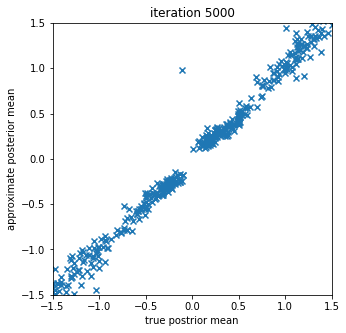

Epoch [5/10], Loss: 34.2480, Perplexity: 747692223055870.88

epoch 6 iteration 5000 loss 35.574 CE 33.771 KL 1.803 weighted KL: 1.803 weight 1.000
epoch 6 iteration 5100 loss 32.074 CE 30.316 KL 1.758 weighted KL: 1.758 weight 1.000
epoch 6 iteration 5200 loss 33.459 CE 31.733 KL 1.726 weighted KL: 1.726 weight 1.000
epoch 6 iteration 5300 loss 29.072 CE 27.286 KL 1.786 weighted KL: 1.786 weight 1.000
epoch 6 iteration 5400 loss 31.576 CE 29.770 KL 1.806 weighted KL: 1.806 weight 1.000
epoch 6 iteration 5500 loss 29.539 CE 27.756 KL 1.784 weighted KL: 1.784 weight 1.000
epoch 6 iteration 5600 loss 31.430 CE 29.613 KL 1.817 weighted KL: 1.817 weight 1.000
epoch 6 iteration 5700 loss 27.642 CE 25.823 KL 1.819 weighted KL: 1.819 weight 1.000
epoch 6 iteration 5800 loss 32.360 CE 30.499 KL 1.861 weighted KL: 1.861 weight 1.000
epoch 6 iteration 5900 loss 35.114 CE 33.430 KL 1.684 weighted KL: 1.684 weight 1.000


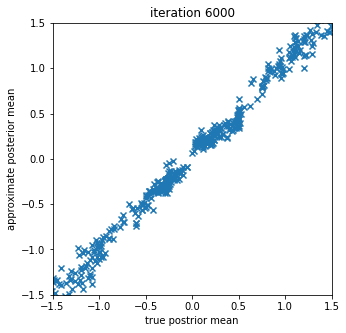

Epoch [6/10], Loss: 33.1301, Perplexity: 244477898631217.50

epoch 7 iteration 6000 loss 35.558 CE 33.842 KL 1.717 weighted KL: 1.717 weight 1.000
epoch 7 iteration 6100 loss 33.247 CE 31.371 KL 1.877 weighted KL: 1.877 weight 1.000
epoch 7 iteration 6200 loss 30.490 CE 28.756 KL 1.734 weighted KL: 1.734 weight 1.000
epoch 7 iteration 6300 loss 29.658 CE 27.936 KL 1.721 weighted KL: 1.721 weight 1.000
epoch 7 iteration 6400 loss 33.437 CE 31.549 KL 1.887 weighted KL: 1.887 weight 1.000
epoch 7 iteration 6500 loss 28.936 CE 27.116 KL 1.819 weighted KL: 1.819 weight 1.000
epoch 7 iteration 6600 loss 32.301 CE 30.491 KL 1.810 weighted KL: 1.810 weight 1.000
epoch 7 iteration 6700 loss 30.006 CE 28.298 KL 1.708 weighted KL: 1.708 weight 1.000
epoch 7 iteration 6800 loss 32.710 CE 30.845 KL 1.865 weighted KL: 1.865 weight 1.000
epoch 7 iteration 6900 loss 27.897 CE 26.216 KL 1.681 weighted KL: 1.681 weight 1.000


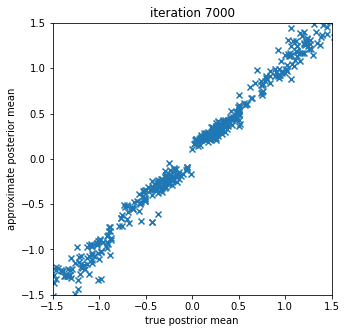

Epoch [7/10], Loss: 31.8705, Perplexity: 69374906548277.44

epoch 8 iteration 7000 loss 29.562 CE 27.950 KL 1.612 weighted KL: 1.612 weight 1.000
epoch 8 iteration 7100 loss 27.031 CE 25.271 KL 1.761 weighted KL: 1.761 weight 1.000
epoch 8 iteration 7200 loss 31.012 CE 29.283 KL 1.729 weighted KL: 1.729 weight 1.000
epoch 8 iteration 7300 loss 33.377 CE 31.682 KL 1.695 weighted KL: 1.695 weight 1.000
epoch 8 iteration 7400 loss 31.501 CE 29.749 KL 1.752 weighted KL: 1.752 weight 1.000
epoch 8 iteration 7500 loss 30.280 CE 28.620 KL 1.660 weighted KL: 1.660 weight 1.000
epoch 8 iteration 7600 loss 30.119 CE 28.564 KL 1.556 weighted KL: 1.556 weight 1.000
epoch 8 iteration 7700 loss 34.588 CE 32.831 KL 1.758 weighted KL: 1.758 weight 1.000
epoch 8 iteration 7800 loss 25.978 CE 24.265 KL 1.712 weighted KL: 1.712 weight 1.000
epoch 8 iteration 7900 loss 31.179 CE 29.456 KL 1.724 weighted KL: 1.724 weight 1.000


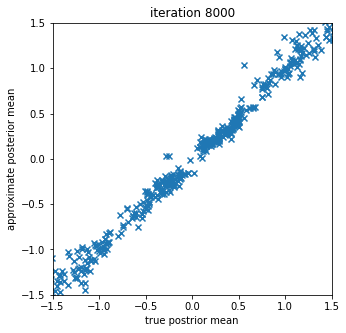

Epoch [8/10], Loss: 30.2859, Perplexity: 14223319198244.54

epoch 9 iteration 8000 loss 28.178 CE 26.434 KL 1.744 weighted KL: 1.744 weight 1.000
epoch 9 iteration 8100 loss 27.786 CE 25.957 KL 1.829 weighted KL: 1.829 weight 1.000
epoch 9 iteration 8200 loss 30.411 CE 28.715 KL 1.695 weighted KL: 1.695 weight 1.000
epoch 9 iteration 8300 loss 29.497 CE 27.804 KL 1.693 weighted KL: 1.693 weight 1.000
epoch 9 iteration 8400 loss 29.214 CE 27.502 KL 1.711 weighted KL: 1.711 weight 1.000
epoch 9 iteration 8500 loss 28.904 CE 27.140 KL 1.764 weighted KL: 1.764 weight 1.000
epoch 9 iteration 8600 loss 30.750 CE 28.998 KL 1.752 weighted KL: 1.752 weight 1.000
epoch 9 iteration 8700 loss 31.521 CE 29.806 KL 1.715 weighted KL: 1.715 weight 1.000
epoch 9 iteration 8800 loss 32.319 CE 30.726 KL 1.593 weighted KL: 1.593 weight 1.000
epoch 9 iteration 8900 loss 31.439 CE 29.688 KL 1.750 weighted KL: 1.750 weight 1.000


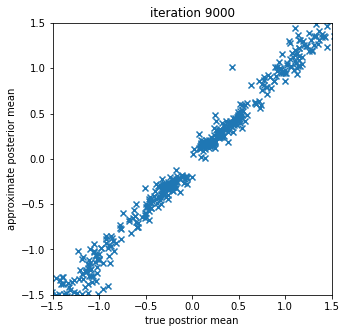

Epoch [9/10], Loss: 26.7181, Perplexity: 401346894846.40

epoch 10 iteration 9000 loss 32.605 CE 30.897 KL 1.709 weighted KL: 1.709 weight 1.000
epoch 10 iteration 9100 loss 29.163 CE 27.473 KL 1.690 weighted KL: 1.690 weight 1.000
epoch 10 iteration 9200 loss 32.543 CE 30.812 KL 1.731 weighted KL: 1.731 weight 1.000
epoch 10 iteration 9300 loss 28.157 CE 26.444 KL 1.713 weighted KL: 1.713 weight 1.000
epoch 10 iteration 9400 loss 36.193 CE 34.389 KL 1.805 weighted KL: 1.805 weight 1.000
epoch 10 iteration 9500 loss 29.724 CE 28.025 KL 1.699 weighted KL: 1.699 weight 1.000
epoch 10 iteration 9600 loss 30.247 CE 28.545 KL 1.702 weighted KL: 1.702 weight 1.000
epoch 10 iteration 9700 loss 26.802 CE 24.935 KL 1.867 weighted KL: 1.867 weight 1.000
epoch 10 iteration 9800 loss 27.239 CE 25.490 KL 1.749 weighted KL: 1.749 weight 1.000
epoch 10 iteration 9900 loss 26.459 CE 24.863 KL 1.596 weighted KL: 1.596 weight 1.000


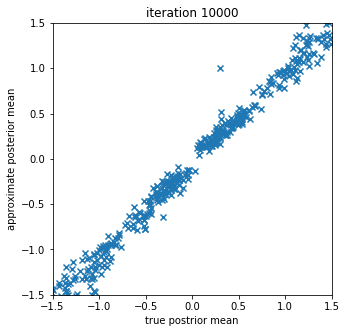

Epoch [10/10], Loss: 31.5924, Perplexity: 52527483064529.07



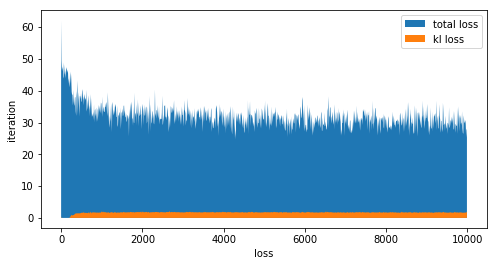

In [30]:
# aggresive training
vocab_size = 1000
hidden_size = 50
embedding_size = 50
latent_size = 1
num_layers = 1
step = 0.25
learning_rate = 0.01
epochs = 10
max_sentence_length = 10

embedding_weights = nn.Embedding(vocab_size, embedding_size).weight
vae = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=True)

train(vae, inputs, targets, val_inputs, val_targets, epochs, vocab_size, hidden_size, latent_size, max_sentence_length, plot=True, learning_rate=learning_rate,
      synthetic=True, step=step, tracked_inputs=tracked_inputs, tracked_targets=tracked_targets, plot_lim=1.5, is_aggressive=True)

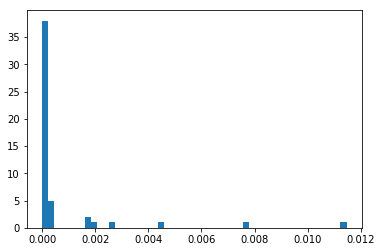

In [31]:
hist_active_units(vae, inputs)

### Interpolate

# TEXT DATA

### Load Penn Treebank data

In [87]:
max_sentence_length = 50
train_data, train_data_padded = load_data("data/ptb.train.txt", max_sentence_length)
val_data, val_data_padded = load_data("data/ptb.valid.txt", max_sentence_length)
test_data, test_data_padded = load_data("data/ptb.test.txt", max_sentence_length)

In [170]:
embedding_size = 500
epochs_w2v = 100

word2vec_model = Word2Vec(train_data, min_count=1, size=embedding_size, window=5)
word2vec_model.train(train_data, epochs=epochs_w2v, total_examples=word2vec_model.corpus_count)

word2vec_model = Word2Vec.load("word2vec.model")
# print(word2vec_model.wv.most_similar("stocks"))
# word2vec_model.wv['credit']

vocabulary_size = len(word2vec_model.wv.vocab)
# print("size of the vocabulary:", vocabulary_size)
# word2vec_model.save("word2vec.model")

c:\users\matosevic\appdata\local\programs\python\python37\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


KeyboardInterrupt: 

In [44]:
# make the word embeddings into a pythorch tensor
embedding_weights = word2vec_model.wv.vectors
embedding_weights = np.vstack((embedding_weights, np.zeros((1,embedding_size))))  # add zero vector for <pad>
embedding_weights = torch.tensor(embedding_weights)

In [45]:
batch_size = 20
use_first_k = 500
padding_index = vocabulary_size
train_batches, train_targets, train_sentence_lens = get_batches_text(train_data[:use_first_k], train_data_padded[:use_first_k], 
                                                                batch_size, padding_index, word2vec_model)

In [46]:
#with annealing
vocab_size = 1000
hidden_size = 50
embedding_size = 50
latent_size = 2
num_layers = 1
step = 0.25
learning_rate = 0.01
epochs = 1

vae = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=False)

annealing_args = {'type':'logistic', 'step':0, 'k':0.0025, 'first_step':2500}

train(vae, inputs, targets, val_inputs, val_targets, epochs, vocab_size, hidden_size, latent_size, max_sentence_length, plot=False, learning_rate=learning_rate,
      synthetic=True, step=step, plot_lim=3, annealing_args=annealing_args, tracked_inputs=tracked_inputs, 
      tracked_targets=tracked_targets)

### Inference/Generation/Interpolation

In [25]:
def generate(vae, z, first_word_index, last_word_index, max_sentence_length):
    generator_batch_size = z.shape[0]
    hidden_concatenated = vae.stochastic_decoder.forward(z)
    hidden = torch.split(hidden_concatenated, vae.hidden_dim, dim=-1)
    generated_sequence = greedy(vae, hidden, first_word_index, last_word_index, max_sentence_length, generator_batch_size)
    return generated_sequence

def greedy(vae, hidden, first_word_index, last_word_index, max_sentence_length, generator_batch_size):
    vae_decoder = vae.decoder   
    first_word_index = torch.tensor(first_word_index, dtype=torch.long)
    predicted = []
    curr_words = torch.tensor([first_word_index] * generator_batch_size, dtype=torch.long).unsqueeze(1)
    iteration = 0
    while iteration != max_sentence_length: #next_word_index != last_word_index and
        curr_words_embeddings = vae_decoder.embed(curr_words)
        curr_words_embeddings = curr_words_embeddings.view(generator_batch_size, 1, vae_decoder.embedding_size)
        
        outputs, hidden = vae_decoder.lstm(curr_words_embeddings.float(), (hidden[0].unsqueeze(0), hidden[1].unsqueeze(0)))
        outputs = vae_decoder.linear(outputs)
        outputs = outputs.squeeze(1)
        hidden = (hidden[0].squeeze(0), hidden[1].squeeze(0))
        softmax_outputs = F.softmax(outputs, dim=1).detach().numpy()
    
        next_words_indices = []
        for t in range(generator_batch_size):
            
            # IS THE NEXT LINE OK? DO INDICES MATCH PROBABILITES?            
            
            next_words_indices.append(np.random.choice(np.arange(softmax_outputs.shape[1]), size=1, p=softmax_outputs[t])[0])        
        curr_words = torch.tensor(next_words_indices, dtype=torch.long).unsqueeze(1)
                
        predicted.append(next_words_indices)

        iteration += 1
        
#     if predicted[-1] != last_word_index:
#         predicted.append(last_word_index)
    return predicted

In [26]:
z1 = torch.randn([latent_size]).numpy()
z2 = torch.randn([latent_size]).numpy()
number_of_sentences_to_decode = 2
max_sentence_length = 10
interpolation_points = generate_interpolation_sequence(z1, z2, number_of_sentences_to_decode=number_of_sentences_to_decode)

sentences = generate(vae, torch.tensor(interpolation_points, dtype=torch.float), word2vec_model.wv.vocab['<sos>'].index, word2vec_model.wv.vocab['<eos>'].index, max_sentence_length)
words_sentences = []
sentences = np.array(sentences).T
for curr_sentence in sentences:
    words_curr_sentence = []
    for j in curr_sentence:
        words_curr_sentence.append(word2vec_model.wv.index2word[j])
    words_sentences.append(words_curr_sentence)
for s in words_sentences:
    for word in s:
        print(word, end = ' ')
    print()

NameError: name 'word2vec_model' is not defined

### Create Word2Vec word embeddings

### Define RNNLM

In [25]:
class RNNLM(nn.Module):
    def __init__(self, vocabulary_size, embedding_size, hidden_size, num_layers, embedding_weights):
        super(RNNLM, self).__init__()
        self.embed = nn.Embedding.from_pretrained(embedding_weights)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocabulary_size)
        self.embedding_size = embedding_size
        
    def forward(self, x, hidden, x_lens, train=True):
        batch_size, max_len, _ = x.shape
        embedding_dim = self.embedding_size

        x = self.embed(torch.tensor(x, dtype=torch.long)).view(batch_size, max_len, embedding_dim)
        if train:
            x_lens = torch.tensor(x_lens, dtype=torch.long)
            x = pack_padded_sequence(x, x_lens, batch_first=True)

        out, hidden = self.lstm(x.float(), hidden) 
        
        if train:
            out, output_lens = pad_packed_sequence(out, batch_first=True, total_length=max_sentence_length-1)

        out = out.reshape(out.size(0)*out.size(1), out.size(2))
        out = self.linear(out)
        
        return out, hidden

### Train and predict with RNNLM

In [42]:
input_size = 100
output_size = 100
hidden_size = 50

batch_size = 20
use_first_k = 500
padding_index = vocabulary_size
train_batches, train_targets, train_sentence_lens = get_batches_text(train_data[:use_first_k], train_data_padded[:use_first_k], 
                                                                batch_size, padding_index, word2vec_model)

# make the word embeddings into a pythorch tensor
embedding_weights = word2vec_model.wv.vectors
embedding_weights = np.vstack((embedding_weights, np.zeros((1,embedding_size))))  # add zero vector for <pad>
embedding_weights = torch.tensor(embedding_weights)

learning_rate = 0.001
num_layers = 1
epochs = 100

model = RNNLM(vocabulary_size, embedding_size, hidden_size, num_layers, embedding_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    hidden = (torch.zeros(num_layers, batch_size, hidden_size), torch.zeros(num_layers, batch_size, hidden_size))
    for i in range(len(train_batches)):
        x = train_batches[i]
        x_lens = train_sentence_lens[i]
        y = torch.tensor(train_targets[i].reshape(-1), dtype=torch.long)   
        h, c = hidden
        h = h.detach()
        c = c.detach()
        hidden = (h, c)
    
        outputs, hidden = model(x, hidden, x_lens)
        
        mask = (y < padding_index)
        loss = nn.CrossEntropyLoss()(outputs[mask], y[mask])

        model.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

    if epoch % 1 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}, Perplexity: {:5.2f}'
               .format(epoch + 1, epochs, loss.item(), np.exp(loss.item())))

Epoch [1/100], Loss: 8.7546, Perplexity: 6339.97
Epoch [2/100], Loss: 7.1132, Perplexity: 1228.10
Epoch [3/100], Loss: 6.3702, Perplexity: 584.18
Epoch [4/100], Loss: 6.2321, Perplexity: 508.81
Epoch [5/100], Loss: 6.1860, Perplexity: 485.89
Epoch [6/100], Loss: 6.1471, Perplexity: 467.36
Epoch [7/100], Loss: 6.1089, Perplexity: 449.86
Epoch [8/100], Loss: 6.0653, Perplexity: 430.67
Epoch [9/100], Loss: 6.0204, Perplexity: 411.75
Epoch [10/100], Loss: 5.9771, Perplexity: 394.29
Epoch [11/100], Loss: 5.9356, Perplexity: 378.25
Epoch [12/100], Loss: 5.8952, Perplexity: 363.29
Epoch [13/100], Loss: 5.8557, Perplexity: 349.22
Epoch [14/100], Loss: 5.8168, Perplexity: 335.89
Epoch [15/100], Loss: 5.7792, Perplexity: 323.51
Epoch [16/100], Loss: 5.7420, Perplexity: 311.67
Epoch [17/100], Loss: 5.7056, Perplexity: 300.54
Epoch [18/100], Loss: 5.6702, Perplexity: 290.10
Epoch [19/100], Loss: 5.6339, Perplexity: 279.75
Epoch [20/100], Loss: 5.5994, Perplexity: 270.26
Epoch [21/100], Loss: 5.565

In [127]:
# Predict
test_sentences = ["in terms"]
sentence, _ = tokenize_sentence(test_sentences[0], max_sentence_length)
sentence = sentence[:-1]
word_indexes = np.array([word2vec_model.wv.vocab[word].index for word in sentence]).reshape(1, len(sentence), 1)

hidden = (torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size))
h, c = hidden
h = h.detach()
c = c.detach()
hidden = (h, c)

outputs, hidden = model(word_indexes, hidden, x_lens, train=False)
softmax_outputs = F.softmax(outputs, dim=1).detach().numpy()
last_word = softmax_outputs[-1,:]

predicted_next_word_idx = np.random.choice(range(len(last_word)), p=last_word)
print("Argmax: ", word2vec_model.wv.index2word[np.argmax(last_word)])
print("Next word: ", word2vec_model.wv.index2word[predicted_next_word_idx])

### Yelp data

In [76]:
# yelp_data = []
# with open('yelp.csv') as csvfile:
#     spam_reader = csv.reader(csvfile)
#     for i, row in enumerate(spam_reader):
#         sentences = sent_tokenize(row[0])
#         for sentence in sentences:
#             yelp_data.append(sentence)

In [77]:
# number_of_sentences = len(yelp_data)
# training_data_len = int(0.8 * number_of_sentences)

# random_train_indices = np.random.choice(len(yelp_data), training_data_len, replace=False)
# yelp_data_train = [yelp_data[i] for i in random_train_indices]

# all_indices = list(range(number_of_sentences))
# validation_indices = [i for i in all_indices if i not in random_train_indices]
# yelp_data_validation = [yelp_data[i] for i in validation_indices]

In [78]:
# yelp_original_train, yelp_padded_train, yelp_original_validation, yelp_padded_validation = [], [], [], []
# max_sentence_len = 50
# occurrences_train = {}
# for line in yelp_data_train:
#     sentence, padded_sentence, occurrences_train = tokenize_sentence(line, max_sentence_len, occurrences_train)
#     yelp_original_train.append(sentence)
#     yelp_padded_train.append(padded_sentence)
    
# for line in yelp_data_validation:
#     sentence, padded_sentence = tokenize_sentence(line, max_sentence_len)
#     yelp_original_validation.append(sentence)
#     yelp_padded_validation.append(padded_sentence)

In [79]:
# # print(occurrences_train["cox"])
# for i, sent in enumerate(yelp_original_train):
#     for j, w in enumerate(sent):
#         if w != '<unk>' and occurrences_train[w] <= 2:
#              yelp_original_train[i][j] = '<unk>'
# # print(yelp_original_train[498])

In [80]:
# embedding_size = 512
# epochs_w2v = 100

# word2vec_yelp = Word2Vec.load("word2vec_yelp.model")

# # word2vec_yelp = Word2Vec(yelp_original_train, min_count=1, size=embedding_size, window=5)
# # word2vec_yelp.train(yelp_original_train, epochs=epochs_w2v, total_examples=word2vec_yelp.corpus_count)

# # word2vec_yelp.save("word2vec_yelp.model")

In [81]:
# # make the word embeddings into a pythorch tensor
# embedding_weights = word2vec_yelp.wv.vectors
# embedding_weights = np.vstack((embedding_weights, np.zeros((1,embedding_size))))  # add zero vector for <pad>
# embedding_weights = torch.tensor(embedding_weights)

In [82]:
# print(word2vec_yelp.wv.most_similar("coffee"))

In [83]:
# batch_size = 16
# vocabulary_size = len(word2vec_yelp.wv.vocab)
# padding_index = vocabulary_size

# yelp_train_inputs, yelp_train_targets, yelp_train_lengths = \
#                 get_batches_text(yelp_original_train, yelp_padded_train, batch_size, padding_index, word2vec_yelp)

# yelp_val_inputs, yelp_val_targets, yelp_val_lengths = \
#                 get_batches_text(yelp_original_validation, yelp_padded_validation, batch_size, padding_index, word2vec_yelp)

In [84]:
# hidden_size = 1024
# latent_size = 1
# num_layers = 1
# step = 0.25
# learning_rate = 0.01
# epochs = 5
# max_sentence_length = 50

# vae = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=True)

# train(vae, yelp_train_inputs[:10], yelp_train_targets[:10], yelp_val_inputs, epochs, vocabulary_size, 
#       hidden_size, latent_size, max_sentence_length, yelp_train_lengths[:10], plot=False, learning_rate=learning_rate,
#       synthetic=False, step=step, tracked_inputs=None, tracked_targets=None, plot_lim=1.5)

In [94]:
max_sentence_len = 50
yelp_train_data_original, yelp_train_data_padded = load_data("yelp_data/yelp.train.txt", max_sentence_len, with_labels=True)
yelp_test_data_original, yelp_test_data_padded = load_data("yelp_data/yelp.test.txt", max_sentence_len, with_labels=True)
yelp_val_dat_original, yelp_val_data_padded = load_data("yelp_data/yelp.valid.txt", max_sentence_len, with_labels=True)

In [96]:
embedding_size = 512
epochs_w2v = 100
word2vec_model_name = "word2vec_yelp.model"

if os.path.isfile(word2vec_model_name):
    print('Loading word2vec model:', word2vec_model_name)
    word2vec_yelp = Word2Vec.load(word2vec_model_name)
else:
    print('Training word2vec model')
    word2vec_yelp = Word2Vec(yelp_train_data_original, min_count=1, size=embedding_size, window=5)
    word2vec_yelp.train(yelp_train_data_original, epochs=epochs_w2v, total_examples=word2vec_yelp.corpus_count)
    word2vec_yelp.save(word2vec_model_name)
    print('Saved word2vec model:', word2vec_model_name)

Loading word2vec model: word2vec_yelp.model


In [97]:
# make the word embeddings into a pythorch tensor
embedding_weights = word2vec_yelp.wv.vectors
embedding_weights = np.vstack((embedding_weights, np.zeros((1,embedding_size))))  # add zero vector for <pad>
embedding_weights = torch.tensor(embedding_weights)

In [98]:
print(word2vec_yelp.wv.most_similar("coffee"))

[('espresso', 0.4220765233039856), ('latte', 0.4194532632827759), ('coffees', 0.3947860598564148), ('tea', 0.3870597183704376), ('americano', 0.3859608769416809), ('expresso', 0.3769384026527405), ('chai', 0.36947500705718994), ('ice', 0.3381340205669403), ('mocha', 0.3350461423397064), ('food', 0.3300296664237976)]


In [99]:
batch_size = 16
vocabulary_size = len(word2vec_yelp.wv.vocab)
padding_index = vocabulary_size

yelp_train_inputs, yelp_train_targets, yelp_train_lengths = \
                get_batches_text(yelp_train_data_original, yelp_train_data_padded, batch_size, padding_index, word2vec_yelp, '_unk')

yelp_test_inputs, yelp_test_targets, yelp_test_lengths = \
                get_batches_text(yelp_test_data_original, yelp_test_data_padded, batch_size, padding_index, word2vec_yelp, '_unk')

yelp_val_inputs, yelp_val_targets, yelp_val_lengths = \
                get_batches_text(yelp_val_dat_original, yelp_val_data_padded, batch_size, padding_index, word2vec_yelp, '_unk')

In [102]:
hidden_size = 1024
latent_size = 1
num_layers = 1
step = 0.25
learning_rate = 0.01
epochs = 5

vae = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=True)

train(vae, yelp_train_inputs[:], yelp_train_targets[:], yelp_val_inputs, yelp_val_targets, epochs, vocabulary_size, 
      hidden_size, latent_size, max_sentence_length, yelp_train_lengths[:], plot=False, learning_rate=learning_rate,
      synthetic=False, step=step, tracked_inputs=None, tracked_targets=None, plot_lim=1.5)

epoch 1 iteration 0 loss 414.365 CE 414.365 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 100 loss nan CE nan KL nan weighted KL: nan weight 1.000
epoch 1 iteration 200 loss nan CE nan KL nan weighted KL: nan weight 1.000


KeyboardInterrupt: 

## ENCODER-DECODER BASELINE

In [67]:
class Baseline(nn.Module):
    # just a basic encoder-decoder with no VAE layers in the middle
    def __init__(self, hidden_dim, num_layers, embedding_weights, synthetic=False):
        super(Baseline, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_first = True
        
        self.encoder = Encoder(self.hidden_dim, num_layers, embedding_weights, synthetic)
        self.decoder = Decoder(self.hidden_dim, num_layers, embedding_weights, synthetic)

        if synthetic:          
            for param in self.parameters():
                nn.init.uniform_(param, -0.01, 0.01)
            nn.init.uniform_(self.encoder.embed.weight, -0.1, 0.1)
            nn.init.uniform_(self.decoder.embed.weight, -0.1, 0.1)
        
    def encode(self, x, x_lens=None):
        batch_size, max_len, _ = x.shape
        hidden = self.encoder.init_hidden(batch_size)
        _, hidden = self.encoder.forward(x, hidden, x_lens)
        return hidden
        
    def decode(self, hidden, x, x_lens=None, train=True): 
        outputs, _ = self.decoder.forward(x, hidden, x_lens, train)
        return outputs
    
    def forward(self, x, x_lens=None):
        # the last hidden state of the encoder is the first hidden state of the decoder
        hidden = self.encode(x, x_lens)
#         hidden_concatenated = self.stochastic_decoder.forward(z)
#         hidden = torch.split(hidden_concatenated, self.hidden_dim, dim=2)
        outputs = self.decode(hidden, x, x_lens)
        return outputs

In [68]:
def baseline_loss_function(outputs, labels, seq_length, mask=None):
    if mask is not None:
        BCE = torch.zeros(mean.shape[1] * (seq_length - 1))
        BCE[mask] = nn.CrossEntropyLoss(reduction='none')(outputs, labels)
    else:
        BCE = nn.CrossEntropyLoss(reduction='none')(outputs, labels)
    BCE = BCE.view(mean.shape[1], -1).sum(-1)
    return BCE

In [69]:
def test_baseline(model, inputs, targets, input_lens, synthetic=False):
    total_loss = 0
    num_words = num_sents = 0
    for i in np.random.permutation(len(inputs)):
        x = inputs[i]
        y = torch.tensor(targets[i].reshape(-1), dtype=torch.long)
        x_lens = input_lens[i] if not synthetic else None

        batch_size, sents_len, _ = x.shape
        if synthetic:
            num_words += batch_size * sents_len
        else:
            num_words = np.sum(x_lens)
        num_sents += batch_size
        
        mask = None
        outputs = model(x, x_lens=x_lens)
        if not synthetic:
            mask = (y < padding_index)
            outputs = outputs[mask]
            y = y[mask]
        curr_loss = baseline_loss_function(outputs, y, max_sentence_length, mask=mask)
        curr_loss = np.sum(curr_loss.data.numpy())
        total_loss += curr_loss.item()
    
    total_loss /= num_sents
    ppl = np.exp(total_loss * num_sents / num_words)
    return total_loss, ppl

In [88]:
def train_baseline(model, inputs, targets, val_inputs, val_targets, epochs, vocab_size, hidden_size, 
                   max_sentence_length, input_lens=None, val_input_lens=None, synthetic=False, 
                   num_layers=1, learning_rate=0.001, verbose_level=1, plot=False):

    opt_dict = {"not_improved": 0, "lr": 1.0, "best_loss": 1e4}
    decay_epoch = 2
    lr_decay = 0.5
    max_decay = 5
    decay_cnt = 0
    
    enc_optimizer = torch.optim.SGD(model.encoder.parameters(), lr=learning_rate)
    dec_optimizer = torch.optim.SGD(model.decoder.parameters(), lr=learning_rate)

    iteration = 0
    train_losses = []
    val_losses = []
            
    for epoch in range(epochs):        
        for i in np.random.permutation(len(inputs)):
            x = inputs[i]
            y = torch.tensor(targets[i].reshape(-1), dtype=torch.long)
            x_lens = input_lens[i] if not synthetic else None 
            
            mask = None
            # do the forward pass
            outputs = model(x, x_lens=x_lens)

            if not synthetic:
                mask = (y < padding_index)
                outputs = outputs[mask]
                y = y[mask]
            
            enc_optimizer.zero_grad()
            dec_optimizer.zero_grad()
            
            # compute the cross entropy loss
            loss = baseline_loss_function(outputs, y, max_sentence_length, mask=mask)                
            loss = loss.mean(dim=-1) # take the mean (same as divide by batch size?)
            
            # backward pass
            loss.backward()
            clip_grad_norm_(model.parameters(), 5.0)
            enc_optimizer.step()
            dec_optimizer.step()
            
            if (iteration % 100 == 0) and (verbose_level == 2):
                print('epoch {}\titeration {}\ttraining loss {:.3f}'.format(epoch+1, iteration, loss))

            iteration += 1
              
        # evaluate on the validation data
        model.eval()
        with torch.no_grad():
            train_loss, train_ppl = test_baseline(model, inputs, targets, input_lens, synthetic)
            val_loss, val_ppl = test_baseline(model, val_inputs, val_targets, val_input_lens, synthetic)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            if verbose_level > 0:
                print ('Epoch [{}/{}], Training Loss: {:.4f} Perplexity: {:.4f}, Validation Loss: {:.4f} Perplexity {:.4f}'
                       .format(epoch+1, epochs, train_loss, train_ppl, val_loss, val_ppl))

            # are we still decaying with the same logic?
            if val_loss > opt_dict["best_loss"]:
                opt_dict["not_improved"] += 1
                if opt_dict["not_improved"] >= decay_epoch:
                    opt_dict["best_loss"] = val_loss
                    opt_dict["not_improved"] = 0
                    opt_dict["lr"] = opt_dict["lr"] * lr_decay
                    #vae.load_state_dict(torch.load(args.save_path))
                    print('new lr: %f' % opt_dict["lr"])
                    decay_cnt += 1

                    enc_optimizer = torch.optim.SGD(model.encoder.parameters(), lr=opt_dict["lr"])
                    dec_optimizer = torch.optim.SGD(model.decoder.parameters(), lr=opt_dict["lr"])
            else:
                opt_dict["not_improved"] = 0
                opt_dict["best_loss"] = val_loss
            
            if decay_cnt == max_decay:
                break
        model.train()
    
    if plot:
        plt.plot(train_losses)
        plt.plot(val_losses)
        plt.show()

Epoch [1/20], Training Loss: 45.0593 Perplexity: 149.3938, Validation Loss: 45.2653 Perplexity 152.8539
Epoch [2/20], Training Loss: 44.9418 Perplexity: 147.4558, Validation Loss: 45.0869 Perplexity 149.8533
Epoch [3/20], Training Loss: 42.7501 Perplexity: 115.5851, Validation Loss: 42.9518 Perplexity 118.2054
Epoch [4/20], Training Loss: 37.4140 Perplexity: 63.8866, Validation Loss: 37.6874 Perplexity 65.8569
Epoch [5/20], Training Loss: 34.2330 Perplexity: 44.8653, Validation Loss: 34.6192 Perplexity 46.8323
Epoch [6/20], Training Loss: 34.1560 Perplexity: 44.4834, Validation Loss: 34.4774 Perplexity 46.1002
Epoch [7/20], Training Loss: 31.3014 Perplexity: 32.3925, Validation Loss: 31.7212 Perplexity 33.9396
Epoch [8/20], Training Loss: 29.7714 Perplexity: 27.3285, Validation Loss: 30.2401 Perplexity 28.7895
Epoch [9/20], Training Loss: 28.8003 Perplexity: 24.5335, Validation Loss: 29.3220 Perplexity 25.9975
Epoch [10/20], Training Loss: 28.1737 Perplexity: 22.8835, Validation Loss: 

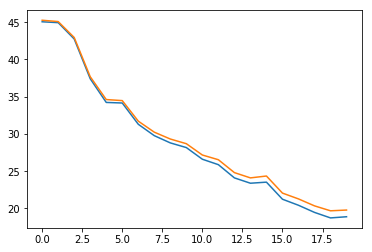

In [89]:
# without annealing
vocab_size = 1000
hidden_size = 50
embedding_size = 50
num_layers = 1
learning_rate = 1.0
epochs = 20
max_sentence_length = 10

embedding_weights = nn.Embedding(vocab_size, embedding_size).weight
baseline_model = Baseline(hidden_size, num_layers, embedding_weights, synthetic=True)

# verbose level 0 - print nothing
# verbose level 1 - print only at the end of each epoch
# verbose level 2 - print everything
verbose_level = 1

train_baseline(baseline_model, inputs, targets, val_inputs, val_targets, epochs, vocab_size, hidden_size, max_sentence_length, 
               learning_rate=learning_rate, synthetic=True, verbose_level=verbose_level, plot=True)